# Bayesian MBG estimation

## Geostatistical Modeling

In [27]:
import pymc as pm
#import aesara.tensor as at
#from aesara.graph.basic import Constant
import os
import pickle
import numpy as np
import arviz as az
import pandas as pd


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
import pytensor.tensor as at
import functions

import uuid

In [28]:
# Get the number of CPU cores to max out the machine in the traning stage
num_cores = os.cpu_count()

print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 10


### Parameters

In [29]:
#Load report
with open('temp_files/report/report.pkl', 'rb') as pickle_file:
    report = pickle.load(pickle_file)

In [30]:
report

{'Country': 'KHM',
 'DHS survey year': 2005,
 'Target Indicator': 'rate_nutr',
 'Urban-rural threshold': 25,
 'Covariates before filtering': 81,
 'Variogram Range': np.float64(0.2562914034453799),
 'Suggested ls beta': 2.0,
 'Covariates after square and square-root transforms': 67,
 'Covariates after pairwise interactions': 2278,
 'Target mean pre transform': np.float64(0.37988868077513227),
 'Target std pre transform': np.float64(0.17326739454356768),
 'Transformation Applied': 'none',
 'Lambda': None,
 'Number of covariates selected after Lasso': 16}

In [31]:
target_indicator = report['Target Indicator']

In [32]:
#Define the directory where the pickle files are stored
pickle_dir = 'temp_files'

### Load the target and the covariates

In [33]:
gdf = pd.read_pickle('temp_files/selected_features.pkl')

In [36]:
# Extract coordinates from the geometry column (using centroid for Polygons)
coordinates = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry])

# Extract coordinates from the geometry column (using centroid for Polygons) only for observed rows
coordinates_observed = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[~gdf[target_indicator].isnull()].geometry])

# Extract coordinates from the geometry column (using centroid for Polygons) only for unobserved rows
coordinates_unobserved = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[gdf[target_indicator].isnull()].geometry])

In [37]:
#Drop geometry
df = gdf.drop('geometry', axis=1)

In [38]:
#Only rows with observed target indicator
df1 = df[~df[target_indicator].isnull()]

In [39]:
#Save sampled df1 for next notebook
with open('temp_files/report/df1_sample.pkl', 'wb') as pickle_file:
    pickle.dump(df1, pickle_file)

### Transform the target indicator

In [40]:
## Select and apply the best transformation
target_transformed, transform, lmda = functions.select_transformation(df1[[target_indicator]])

## Store important information for reversion

report['Transformation Applied'] = transform #Transformation applied to target
report['Lambda'] = lmda #Store lambda variable for some reversion processes

## Replace target for target_transformed in the df
df1[target_indicator] = target_transformed

Skewness: 0.45970678498069134, Kurtosis: 0.29514266385129684
No transformation applied due to low skewness and non-positive values.


/var/folders/wn/vzyjwy2x00q4stf523pr30jw0000gn/T/ipykernel_36511/538854860.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[target_indicator] = target_transformed


In [41]:
selected_features = df1.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'PHUMCODE']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [43]:
# Covariate matrix
X = df1[selected_features].values

# Series with the target variable observed
response = df1[target_indicator].values

In [44]:
#Store the mean and the std for inverse transformation
report['Target mean'] = response.mean()
report['Target std'] = response.std()

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [46]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaler_y = StandardScaler()
response = scaler_y.fit_transform(response.reshape(-1, 1)).flatten()

In [47]:
#Standarize the coordinates
# Initialize the StandardScaler
scaler_coordinates = StandardScaler()

# Standardize the coordinates
coordinates_observed = scaler_coordinates.fit_transform(coordinates_observed)

In [48]:
report['Observations used to train the model'] = response.shape[0]

### Bayesian Model Training

Key Components of the Model

    Priors:
        beta: Coefficients for the linear model, assumed to follow a normal distribution with mean 0 and standard deviation 1.
        sigma: Standard deviation of the observation noise, assumed to follow a half-normal distribution with standard deviation 1.
        ls: Length-scale parameter for the spatial covariance function, assumed to follow a half-Cauchy distribution with scale parameter 1.

    Spatial Distance Matrix:
        D: Matrix of Euclidean distances between all pairs of observed locations.

    Covariance Function:
        K: Covariance function (Matern 5/2) which defines the spatial correlation structure.

    Gaussian Process (GP):
        gp: Latent Gaussian process with the defined covariance function.
        f: Prior distribution of the GP evaluated at the observed coordinates.

    Linear Model:
        mu: Mean of the linear model which is a combination of the linear predictor (X * beta) and the spatial effect (f).
        y_obs: Observed responses, modeled as a normal distribution with mean mu and standard deviation sigma.

    Inference:
        Using Automatic Differentiation Variational Inference (ADVI) to approximate the posterior distribution of the model parameters.
        advi_fit: Fitting the model using ADVI.
        trace: Sampling from the fitted model to obtain posterior samples.

In [49]:
print(f'Observations to train on {response.shape[0]}')

Observations to train on 310


In [50]:
report['Variogram Range']

np.float64(0.2562914034453799)

In [ ]:
%%time
# Fit a Bayesian geostatistical model
with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=report['Target mean'], sigma=report['Target std'], shape=len(selected_features))
    #beta = pm.Normal('beta', mu=0, sigma=1, shape=len(selected_features))
    #sigma = pm.HalfNormal('sigma', sigma=report['Target std'])
    sigma = pm.HalfNormal('sigma', sigma=1)
    
   #ls = pm.HalfCauchy('ls', beta=report['Suggested ls beta'])

    ls = pm.HalfCauchy('ls', beta=report['Variogram Range'])

    print('Priors run')

    # Spatial distance matrix
    D = np.sqrt(((coordinates_observed[:, None, :] - coordinates_observed[None, :, :])**2).sum(axis=-1))

    print('Distance matrix calculated')

    # Define covariance function
    K = pm.gp.cov.Matern52(2, ls=ls)
    gp = pm.gp.Latent(cov_func=K)
    f = gp.prior('f', X=coordinates_observed)

    print('Covariance run')

    # Linear model
    ## This defines the mean of the normal distribution for the observed data. It combines a linear regression term (pm.math.dot(X, beta)) with the GP latent function f.
    mu = pm.math.dot(X, beta) + f

    ## This defines the likelihood of the observed data (response) as a normal distribution with mean mu and standard deviation sigma.
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=response)

    print('Linear model specified')

    # Inference
    step = pm.NUTS(target_accept=0.95)
    idata = pm.sample(1000, tune=1000, step=step, cores=num_cores, return_inferencedata=True) #The num_cores parameter maxes the machine out. Tweak if needed. 

    print('Model Fitted')


Priors run
Distance matrix calculated
Covariance run
Linear model specified


Multiprocess sampling (10 chains in 10 jobs)
NUTS: [beta, sigma, ls, f_rotated_]


Output()

In [ ]:
#az.to_netcdf(idata, trace_filename)

## Testing the model results

1. Posterior Predictive Checks
2. Prediction Accuracy Metrics
3. Residual Analysis
4. Uncertainty Quantification

### Posterior Predictive Checks:

Posterior Predictive Distribution: Compare the observed data to the posterior predictive distribution of the model. This involves generating new data based on the posterior distributions of the model parameters and comparing these simulated data to the actual observations.


Sampling: [y_obs]


Output()

/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


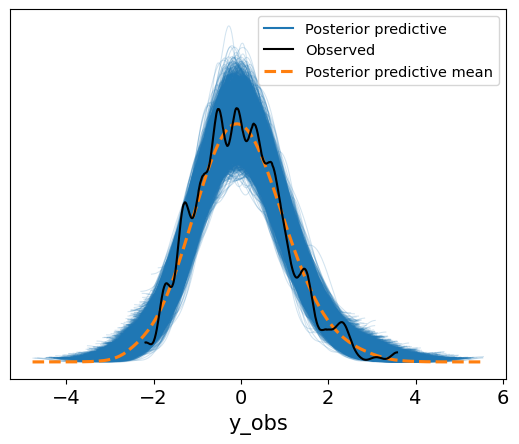

In [ ]:
# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Plot posterior predictive checks
az.plot_ppc(posterior_predictive, kind='kde', data_pairs={'y_obs': 'y_obs'})

# Show the plot
plt.show()

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

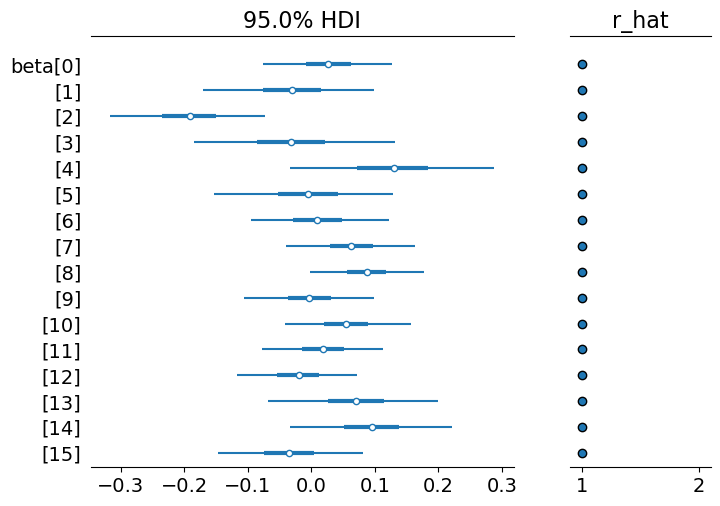

In [ ]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)

#### Trace plots

Interpretation of Trace Plots

    Density Plots (Left Column):
        Each subplot on the left shows the kernel density estimate of the posterior distribution for a parameter.
        These plots give an idea of the central tendency (mean or median) and the spread (variance) of the parameter estimates.
        For example, the density plot for beta shows multiple colored curves corresponding to different chains, indicating the posterior distributions of the coefficients.

    Trace Plots (Right Column):
        Each subplot on the right shows the sampled values of the parameter across iterations for each chain.
        These plots help in assessing the convergence of the Markov Chain Monte Carlo (MCMC) sampling.
        A good trace plot should look like a "hairy caterpillar," with the chains mixing well and no apparent trends or patterns over iterations.

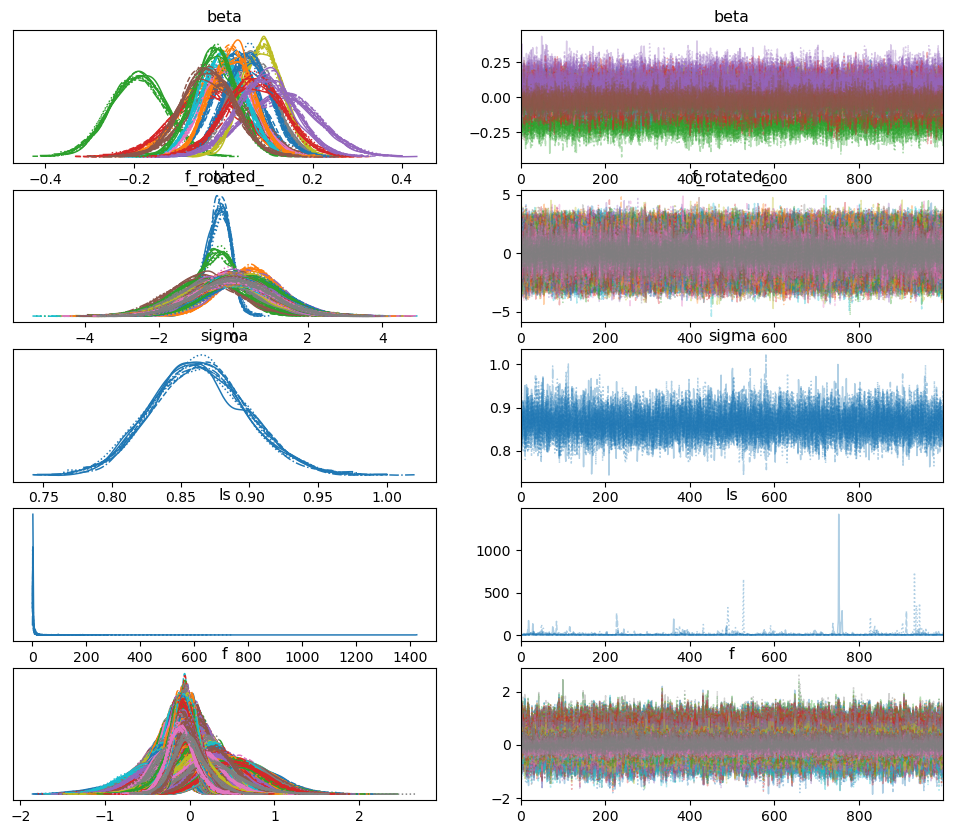

In [ ]:
import matplotlib.pyplot as plt

# Generate the trace plot
trace_plot = az.plot_trace(idata)

# Save the plot to a file
plt.savefig('temp_files/report/9. trace_plot.pdf')

### Residual Analysis

#### Spatial Residual Plots 

Plot residuals (the differences between observed and predicted values) over the spatial domain to check for patterns. Randomly distributed residuals indicate a good fit.

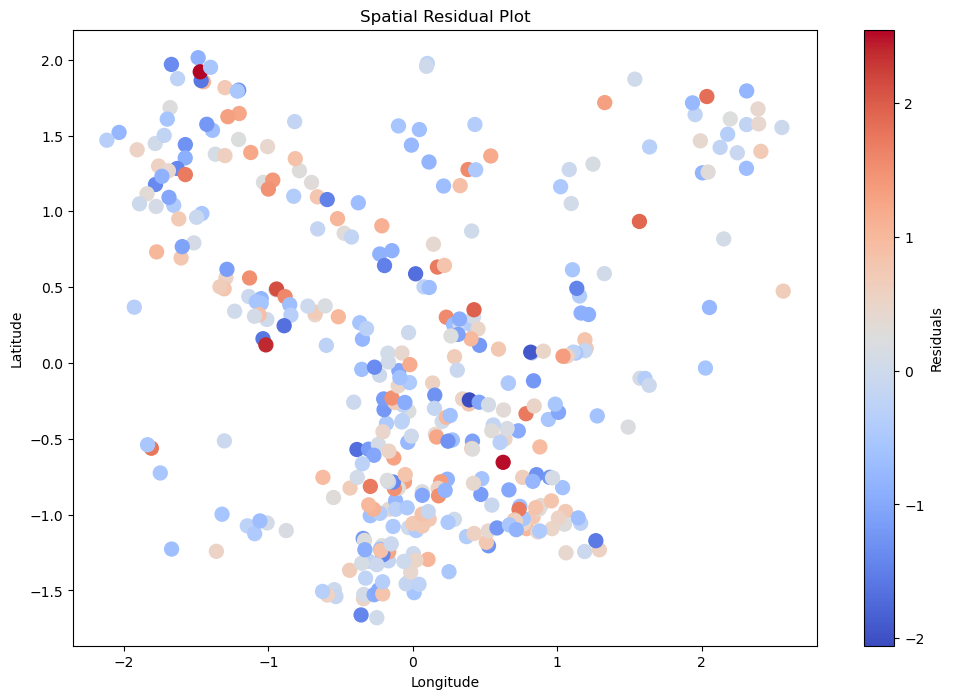

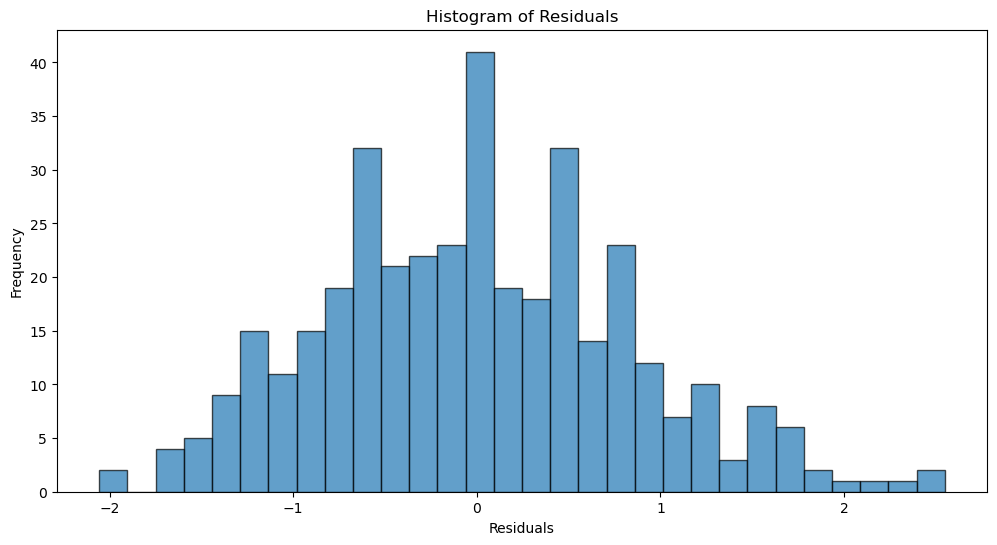

In [ ]:
# Extract the observed data
y_obs = posterior_predictive.observed_data['y_obs'].values

# Calculate the mean of the simulated data across chains and draws
y_sim = posterior_predictive.posterior_predictive['y_obs'].mean(dim=('chain', 'draw')).values

# Calculate residuals
residuals = y_obs - y_sim

# Plot spatial residuals
plt.figure(figsize=(12, 8))
sc = plt.scatter(coordinates_observed[:, 0], coordinates_observed[:, 1], c=residuals, cmap='coolwarm', s=100)
plt.colorbar(sc, label='Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Residual Plot')
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Uncertainty Quantification

	•	Credible Intervals: Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.
	•	Uncertainty Maps: Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.

#### Credible Intervals

Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.

Sampling: [y_obs]


Output()

Coverage of 95% Credible Intervals: 96.83%


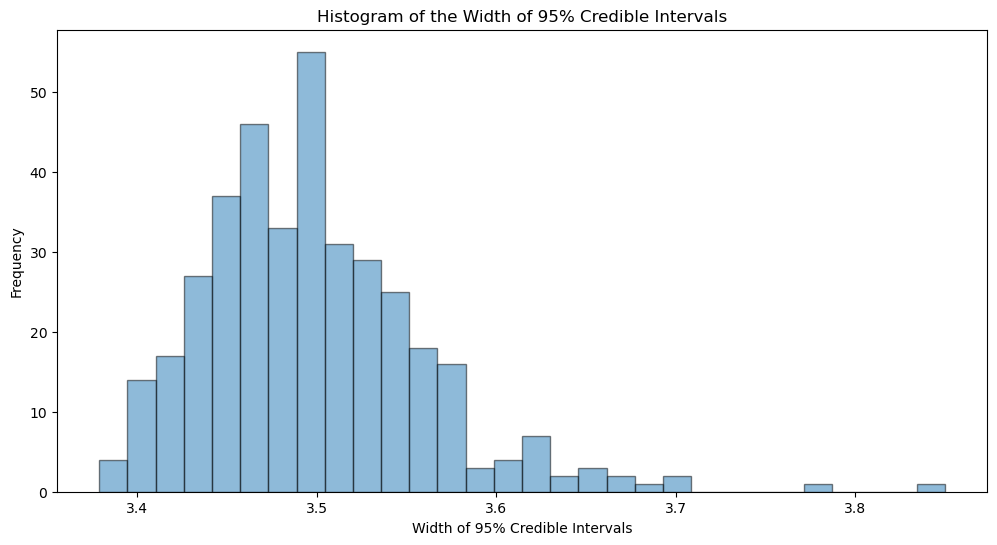

In [ ]:
# Extract the observed and simulated data
y_obs = response

# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Extract the mean prediction, lower and upper bounds of the 95% credible intervals
y_sim = posterior_predictive.posterior_predictive['y_obs'].mean(dim=("chain", "draw")).values
hdi = az.hdi(posterior_predictive.posterior_predictive, hdi_prob=0.95)['y_obs']

# Calculate the width of the credible intervals
ci_width = hdi[:, 1] - hdi[:, 0]

# Check how many true values are within the credible intervals
within_ci = np.sum((y_obs >= hdi[:, 0]) & (y_obs <= hdi[:, 1]))
total_obs = len(y_obs)
coverage = within_ci / total_obs

print(f"Coverage of 95% Credible Intervals: {coverage * 100:.2f}%")



# Plot the width of the credible intervals
plt.figure(figsize=(12, 6))
plt.hist(ci_width, bins=30, edgecolor='k', alpha=0.5)
plt.xlabel('Width of 95% Credible Intervals')
plt.ylabel('Frequency')
plt.title('Histogram of the Width of 95% Credible Intervals')
plt.show()

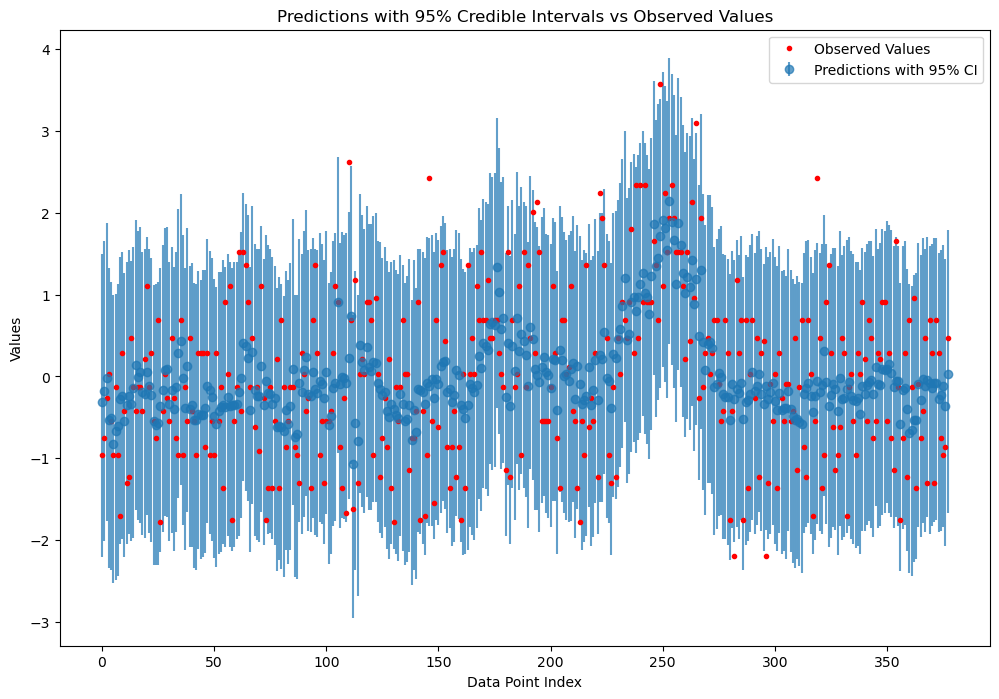

In [ ]:
# Plot the credible intervals vs the observed values
plt.figure(figsize=(12, 8))
plt.errorbar(np.arange(len(y_obs)), y_sim, yerr=[y_sim - hdi[:, 0], hdi[:, 1] - y_sim], fmt='o', alpha=0.7, label='Predictions with 95% CI')
plt.plot(np.arange(len(y_obs)), y_obs, 'r.', label='Observed Values')
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Predictions with 95% Credible Intervals vs Observed Values')
plt.legend()
plt.show()

### Transform the results back to original scale

#### Revert observed

In [ ]:
y_denormalized = functions.revert_standardization(response, report['Target mean'], report['Target std'])

In [ ]:
y_original_scale = functions.revert_transformation(y_denormalized, 
                                report['Transformation Applied'],
                                report['Target mean'], 
                                report['Target std'], 
                               report['Lambda']).round(4)

#### Revert predicted

In [ ]:
y_sim_dn = functions.revert_standardization(y_sim, report['Target mean'], report['Target std'])

In [ ]:
y_sim_original_scale = functions.revert_transformation(y_sim_dn, 
                                report['Transformation Applied'],
                                report['Target mean'], 
                                report['Target std'], 
                               report['Lambda']).round(4)

### Prediction Accuracy Metrics (at original scale)

#### Mean Absolute Error (MAE)

Measures the average magnitude of the errors in a set of predictions, without considering their direction.

In [ ]:
# Calculate the absolute errors
absolute_errors = np.abs(y_original_scale - y_sim_original_scale)

# Calculate the Mean Absolute Error
mae = np.mean(absolute_errors)

print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.11534153439153441


In [ ]:
report['Bayesian model MAE'] = mae

#### Root Mean Squared Error (RMSE) 

Measures the square root of the average of squared differences between predicted and observed values, providing an indication of the model’s overall error.

In [ ]:
# Calculate the squared errors
squared_errors = np.square(y_original_scale - y_sim_original_scale)

# Calculate the Mean Squared Error (MSE)
mse = np.mean(squared_errors)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.14416843168017643


In [ ]:
report['Bayesian RMSE'] = rmse

In [ ]:
#Save report as pickle
with open('temp_files/report/report.pkl', 'wb') as pickle_file:
    pickle.dump(report, pickle_file)

In [ ]:
bayesian_report_keys = ['Variogram Range',
                        'Transformation Applied', 
                        'Number of covariates selected after Lasso',  
                        'Observations used to train the model',
                        'Target mean', 
                        'Target std',
                        'Target mean pre transform',
                        'Target std pre transform',
                        'Bayesian model MAE', 
                        'Bayesian RMSE']

In [ ]:
bayesian_report = {key: report[key] for key in bayesian_report_keys if key in report}

In [ ]:
t1 = pd.DataFrame(data={'Data':bayesian_report.keys(), 
                  'Value': bayesian_report.values()}, 
             columns=['Data','Value'])

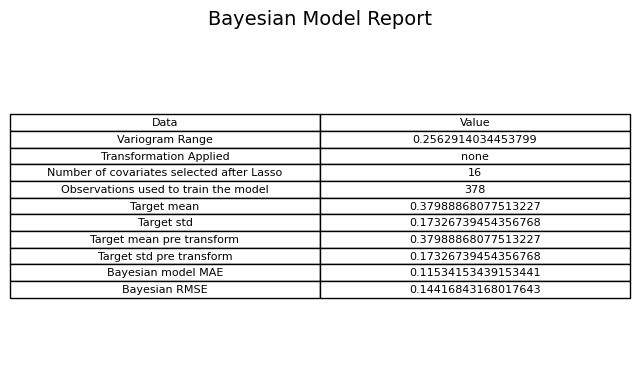

In [ ]:
table_path = os.path.join('temp_files/report/', '14. Bayesian Report.pdf')
title = 'Bayesian Model Report'
functions.df_to_pdf(t1, table_path, title=title, show=True)

# Predictions

In [ ]:
gdf = pd.read_pickle('temp_files/selected_features.pkl')
gdf_full = pd.read_pickle('temp_files/selected_features_full.pkl')

In [ ]:
selected_features = gdf.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'PHUMCODE']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [53]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Extract coordinates from the geometry column (using centroid for Polygons)
coordinates = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry])

#Standardize
coordinates = scaler.fit_transform(coordinates)

# Extract coordinates from the geometry column (using centroid for Polygons) only for observed rows
coordinates_observed = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[~gdf[target_indicator].isnull()].geometry])

# Standardize
coordinates_observed = scaler.fit_transform(coordinates_observed)

In [54]:
#Only rows with observed target indicator
df1 = gdf[~gdf[target_indicator].isnull()]

In [55]:
# Select and apply the best transformation
target_transformed, transform, lmda = functions.select_transformation(df1[[target_indicator]])

#Store important information for reversion

report['Transformation Applied'] = transform #Transformation applied to target
report['Lambda'] = lmda #Store lambda variable for some reversion processes

Skewness: 0.40561199931755204, Kurtosis: 0.04372459552329078
No transformation applied due to low skewness and non-positive values.


In [56]:
#Replace target for target_transformed in the df
df1[target_indicator] = target_transformed

/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [57]:
# Transformed target variable
y = df1[target_indicator].values

In [58]:
# Covariate matrix
X = df1[selected_features].values

In [59]:
# Standardize features and transformed y

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [60]:
# Save the scaler to a pickle file
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

In [61]:
#DF with all observations
gdf2 = gdf_full.copy(deep=True) #This line to make predictions for all observations
#gdf2 = gdf2.sample(1000)
df2 = gdf2.copy(deep=True)
df2.reset_index(drop=True, inplace=True)

# Extract coordinates from the geometry column (using centroid for Pcolygons)
coordinates_new = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf2.geometry])

# Standardize
coordinates_new = scaler.fit_transform(coordinates_new)

# Covariate matrix
X_new = df2[selected_features].values

# Standardize the new data using the same scaler fitted on the observed data
X_new = scaler_x.transform(X_new)

In [62]:
begin_from_scratch = True
    
if begin_from_scratch == True: 
    #Dataframe to store predictions and other values for uncertainty calculations
    df3 = pd.DataFrame(df2[['grid_id', target_indicator]].head(0))
    start_position=0

else:
    #Pick-up productions were we left of. 
    with open('temp_files/predictions.pkl', 'rb') as pickle_file:
        df3 = pickle.load(pickle_file)
    start_position = df3.index.max() + 1

In [63]:
import scipy.stats as stats

In [64]:
# Assuming 95% confidence level, change alpha for different confidence levels
alpha = 0.05
z_score = stats.norm.ppf(1 - alpha/2)

In [77]:
#step = 434
step = 2

In [78]:
X_new.shape

(12076, 16)

In [ ]:
# Step is the number of observations to select in each iteration
num_observations = len(X_new)
all_indices = np.arange(num_observations)

for i in range(start_position, num_observations, step):
    
    # Randomly select 'step' indices without replacement for each iteration
    if step <= len(all_indices):
        r = np.random.choice(all_indices, size=step, replace=False)
        all_indices = np.setdiff1d(all_indices, r)  # Remove the selected indices from the pool
    else:
        # If fewer than 'step' indices remain, select all remaining indices
        r = all_indices
        all_indices = np.array([])

    print(f"Remaining indices: {len(all_indices)}")

    # Select the subset of new data points for this batch
    X_new_i = X_new[r]
    coordinates_new_i = coordinates_new[r]

    # Generate a unique variable name for each iteration
    f_pred_name = "f_pred_" + str(uuid.uuid4())

    # Prediction generation using the Gaussian Process and posterior sampling
    with model:
        # Define the Gaussian Process covariance function for new points with jitter for numerical stability
        f_pred = gp.conditional(f_pred_name, Xnew=coordinates_new_i, jitter=1e-3)
    
        # Sampling from the posterior predictive distribution for the new data points
        ppc = pm.sample_posterior_predictive(idata, var_names=[f_pred_name], return_inferencedata=True)

    # Extract 'beta' samples from the original posterior (idata)
    beta_samples = idata.posterior['beta'].values  # Posterior samples for 'beta'

    # Extract GP samples from posterior predictive
    gp_samples = ppc.posterior_predictive[f_pred_name].values  # GP predictions

    # Check dimensions
    print(f"beta_samples shape: {beta_samples.shape}")  # Should be (num_samples, num_features)
    print(f"X_new_i shape: {X_new_i.shape}")            # Should be (num_points, num_features)

    # Calculate the linear component (dot product) for each sample
    # Make sure the dimensions match: (num_samples, num_features) @ (num_features, num_points)
    linear_component = np.dot(beta_samples, X_new_i.T)  # Shape: (num_samples, num_points)

    # Combine the GP predictions and linear component
    combined_predictions = gp_samples + linear_component

    # Create DataFrame for all posterior samples (1000 samples for each observation)
    dfpi = pd.DataFrame(combined_predictions.mean(axis=0))  # The shape should be (1000, num_points)

    # Extracting relevant data for the current batch
    dfi = df2.loc[r][['grid_id', target_indicator]]

    # Combine predictions with the data
    dfi[target_indicator] = dfpi.mean(axis=0).values  # Mean prediction across samples
    dfi['std'] = dfpi.std(axis=0).values               # Standard deviation across samples
    dfi['max'] = dfpi.max(axis=0).values               # Max prediction across samples
    dfi['min'] = dfpi.min(axis=0).values               # Min prediction across samples

    # Calculating the margin of error for the confidence interval
    dfi['standard_error'] = dfi['std'] / (len(dfpi)**0.5)
    dfi['margin_of_error'] = z_score * dfi['standard_error']

    # Calculating the confidence interval
    dfi['ci_lower'] = dfi[target_indicator] - dfi['margin_of_error']
    dfi['ci_upper'] = dfi[target_indicator] + dfi['margin_of_error']

    # Combine with previous results
    df3 = pd.concat([df3, dfi])

    # Save predictions so far
    dfpi.to_pickle('temp_files/dfpi.pkl')  # Save all predictions for the current batch
    df3.to_pickle('temp_files/predictions.pkl')

    # Break the loop if no more indices are left to process
    if len(all_indices) == 0:
        break


Sampling: [f_pred_25208ec7-08f0-41aa-84bb-5b47d00fd5ce]


Output()

Remaining indices: 12074


Sampling: [f_pred_094fce82-2eca-479d-bc8f-07c02d1481fc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12072


Sampling: [f_pred_6b43f0bd-a940-4303-bee7-cea05a328cfe]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12070


Sampling: [f_pred_7fa40d00-9f37-431d-a478-677087e27376]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12068


Sampling: [f_pred_7e28dc2a-ba3a-443e-8228-e223a5df9b18]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12066


Sampling: [f_pred_1d34dd93-5eb3-484d-b9f3-a6875634a155]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12064


Sampling: [f_pred_577f734d-46fc-4aaa-828b-50140c7631b1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12062


Sampling: [f_pred_7033c91a-15b0-404f-8912-0e28fb449fd2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12060


Sampling: [f_pred_4d6f5b22-ddeb-4c5d-9d3f-5ac892837d45]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12058


Sampling: [f_pred_255a7fd8-d89d-44ea-8db2-5aed1ab064b3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12056


Sampling: [f_pred_ebb6d61d-3db3-425a-959d-7218aa8f82a0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12054


Sampling: [f_pred_3d74cba0-da75-495d-8471-d9477358dea5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12052


Sampling: [f_pred_c53d3eca-fd37-4084-8284-edee368f8eb4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12050


Sampling: [f_pred_b9a7de20-978b-4e19-ba78-bf799e0aefec]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12048


Sampling: [f_pred_74112130-63c9-409f-aed5-3acfc51f6e06]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12046


Sampling: [f_pred_a5f38dd2-76e7-411f-a1f1-1eceeb3404ec]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12044


Sampling: [f_pred_9c44c4cd-4f8f-4507-84ec-2becbd8bfed9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12042


Sampling: [f_pred_89263f8f-5fd3-421f-8f23-9ee23326cb50]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12040


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12038


Sampling: [f_pred_c8308c5f-ba7d-4da7-a354-a30747538084]


Output()

Sampling: [f_pred_216372d3-a26d-4bd1-a583-b8953e890b5a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12036


Sampling: [f_pred_b8a5eea0-1292-4be6-b504-99c04b49b6f3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12034


Sampling: [f_pred_d26db736-db0f-4207-8c2b-36ade1e39f34]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12032


Sampling: [f_pred_8909be92-43fa-4eb8-8ee2-33a2e92bafb6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12030


Sampling: [f_pred_165c046c-4e6a-41fb-a653-1f398920671a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12028


Sampling: [f_pred_467be760-83ce-4621-b74c-b6a93b579d86]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12026


Sampling: [f_pred_7f0dcb8c-f199-47cd-b947-bde27ff2a55d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12024


Sampling: [f_pred_acdf7c39-993d-4a8b-afdd-f5c2f78edceb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12022


Sampling: [f_pred_12387da9-3672-4601-a55b-9bd820b15de0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12020


Sampling: [f_pred_8d11cd04-1c8e-4de4-a8dd-415357e6aa42]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12018


Sampling: [f_pred_40c8aaa2-4d9a-49df-859c-8a9d2bbd31cd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12016


Sampling: [f_pred_f793012c-d433-4b5b-bbab-2ddcf425cfdb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12014


Sampling: [f_pred_014e4fe4-027b-40c7-9563-94d1a17c65e1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12012


Sampling: [f_pred_fb06e092-89b8-4260-9aaf-2263edb2610b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12010


Sampling: [f_pred_5f38a3a1-044f-4341-aa91-90caea3297ad]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12008


Sampling: [f_pred_3744569b-8981-4e0a-a843-5897a39e5692]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12006


Sampling: [f_pred_7290f8ab-8f7e-4f5f-95be-af04dc1b601a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12004


Sampling: [f_pred_6e59f8cf-0262-4d5e-ab18-54300168f0be]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12002


Sampling: [f_pred_71bfaf59-eb72-4aca-a771-49161c4e0fa1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 12000


Sampling: [f_pred_78de79f1-95c8-4619-83c1-23569a3b300a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11998


Sampling: [f_pred_9cd6bac7-ae50-45ef-8653-b06c20373938]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11996


Sampling: [f_pred_b81a1454-63cc-47cf-8441-94d57224ed11]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11994


Sampling: [f_pred_a781db29-7964-4af7-a634-4d6697d0bf4e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11992


Sampling: [f_pred_2880a52f-3d7c-4ee9-8a05-e5f1678785f3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11990


Sampling: [f_pred_15dc3258-8cc9-439a-a486-c200a5d45f22]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11988


Sampling: [f_pred_9dc30afd-8852-46d2-b9ed-e6014bde702e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11986


Sampling: [f_pred_5d7e3312-508f-4bb9-9e82-d9dce4c62f5e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11984


Sampling: [f_pred_cbf3bfcd-17eb-41fd-bebb-ce767776e26d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11982


Sampling: [f_pred_f603b8f7-fce5-42ed-8c46-24fdb939b20a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11980


Sampling: [f_pred_b145e883-b83c-4d83-a34b-683c02d60826]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11978


Sampling: [f_pred_ec09670b-2d17-4860-be05-1c507a2585c3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11976


Sampling: [f_pred_ab49675d-6ed8-4ac8-a6d5-7659ff3a45be]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11974


Sampling: [f_pred_dbd5bc84-6553-46d2-9393-a30f4e9d06d7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11972


Sampling: [f_pred_b550656a-2b69-4ecc-96fe-52cb5cc23e73]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11970


Sampling: [f_pred_ebe196f2-0123-4466-805c-95abc0e8677c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11968


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11966


Sampling: [f_pred_0e3eb855-fc71-4a3f-afff-a53f20c99198]


Output()

Sampling: [f_pred_c9de5477-0abf-4757-9f22-578b64892df0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11964


Sampling: [f_pred_25f5840c-c2c2-4bbd-b66c-bc25ae9a76ed]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11962


Sampling: [f_pred_7cc24a16-24e9-409c-9075-781f40562a2d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11960


Sampling: [f_pred_17813e34-b86b-4421-b729-2bd661759c85]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11958


Sampling: [f_pred_9d0dcf46-46b4-4452-9823-be116e760333]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11956


Sampling: [f_pred_0679ffb6-df45-4b4b-b2a9-4225d6667cbd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11954


Sampling: [f_pred_b8dd5e0f-8b0c-49f0-8fb9-59dbb9b08538]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11952


Sampling: [f_pred_db610eb7-21b5-4249-a1b4-fcfab8df14bc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11950


Sampling: [f_pred_215ace1e-81ce-4e13-a942-556cfbb3eaeb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11948


Sampling: [f_pred_99b7b278-edc0-4388-8ab3-e0f5a271c827]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11946


Sampling: [f_pred_46da9e85-ebf2-499d-819c-b13450293f11]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11944


Sampling: [f_pred_b1e1a474-464f-4c73-9b7c-6c6d051e87c1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11942


Sampling: [f_pred_650972a2-803d-4c1c-9463-a25be32f8691]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11940


Sampling: [f_pred_3085c214-7d28-4f69-b296-d62d407eb401]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11938


Sampling: [f_pred_a362ad8f-1ce3-4453-893b-e98e7d573a72]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11936


Sampling: [f_pred_81636fbd-d579-428a-b578-f36db39f09e6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11934


Sampling: [f_pred_2fd2f2e5-ea64-4736-b3a9-9d84cf3e6f6d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11932


Sampling: [f_pred_3c479d2a-3ffd-44b8-a838-20dd132cc6e4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11930


Sampling: [f_pred_38c6d627-b645-4193-8ee7-5f78c3d48ed1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11928


Sampling: [f_pred_b7c1c24b-6cbb-441c-a5b5-f5de8e436e26]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11926


Sampling: [f_pred_61c5a470-0360-4f92-b7b0-b7b097a0f469]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11924


Sampling: [f_pred_d95ba392-cdab-4729-99a9-d6090fa69fb5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11922


Sampling: [f_pred_d1c635e5-1a7d-4158-b9a9-f97fd85d9e1d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11920


Sampling: [f_pred_d18a74d8-add1-4a51-b9c7-245b72b14c50]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11918


Sampling: [f_pred_550979bc-d4cb-4a9d-b257-fb4183b742b7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11916


Sampling: [f_pred_321469fe-51cc-4e39-b185-e8a90cdea84a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11914


Sampling: [f_pred_508d5e7a-19e8-48b2-88ab-205aea53cc1f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11912


Sampling: [f_pred_7737cfd1-b8f0-4267-b57f-f66319c4b03c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11910


Sampling: [f_pred_58368cb8-6d13-4b44-910c-94226bd7513f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11908


Sampling: [f_pred_d788e0f9-5514-4e10-98f4-4c61128e2c7d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11906


Sampling: [f_pred_5277b2f6-8701-4258-9c2a-2c9ec71fba82]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11904


Sampling: [f_pred_67d97d23-a9f8-4a68-8d1a-432d986f3b3a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11902


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11900


Sampling: [f_pred_d743db3f-7490-4560-93f9-5a7056d9fcf5]


Output()

Sampling: [f_pred_20eb4417-9610-474f-a81e-768bbb4eec46]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11898


Sampling: [f_pred_34bcf27c-a173-489c-952b-34d0630db72a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11896


Sampling: [f_pred_2d9a5f75-315a-4e26-9227-2ccc9123eac7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11894


Sampling: [f_pred_714d57c8-58d2-4696-bd79-f40573a5d92d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11892


Sampling: [f_pred_183e2c4c-6002-4fb7-a491-b4484f3d2f77]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11890


Sampling: [f_pred_c9e4dfc6-3345-43e7-a742-3b2ffef4d834]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11888


Sampling: [f_pred_54fb74aa-bc50-461b-9e01-a35b1238924e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11886


Sampling: [f_pred_74ff8d4a-6ae3-41f1-bd12-0a0f034fefe8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11884


Sampling: [f_pred_05f6ab41-689a-4781-a23f-218da76e5df1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11882


Sampling: [f_pred_0117d677-ebc9-4b3a-baac-e300d9e3c51d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11880


Sampling: [f_pred_9466a80e-7a6d-41a2-94b3-26f5dcac1157]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11878


Sampling: [f_pred_5262448d-1568-433f-9dbb-605721713db0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11876


Sampling: [f_pred_b3bffaed-b544-4ecd-bd11-97f10b5036ad]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11874


Sampling: [f_pred_d99a52c7-7379-4e21-a044-51d268775649]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11872


Sampling: [f_pred_274d8b47-046c-4940-a072-16f0411dd3cf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11870


Sampling: [f_pred_ff6a9613-6d6f-49a8-b5fa-8a0f6c7043b3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11868


Sampling: [f_pred_70cf6f13-0189-447e-81e6-03733383294b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11866


Sampling: [f_pred_835b6935-70df-4002-9e78-5fba6f69f784]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11864


Sampling: [f_pred_5c722335-a3ef-4721-b8cf-17b3d35c71ea]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11862


Sampling: [f_pred_fcc69965-100a-4970-aa6d-a66e48fae124]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11860


Sampling: [f_pred_a76fc2fd-0c83-4675-b797-45271f17b75f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11858


Sampling: [f_pred_05fba97c-393a-4747-864b-82193f613b91]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11856


Sampling: [f_pred_c2a56974-4337-47ca-b67d-94dbf50d71fb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11854


Sampling: [f_pred_f3ec8880-f414-42d6-a812-0a0d6ad26939]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11852


Sampling: [f_pred_cfacbae9-57ff-4007-a63e-f5f5157ff59b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11850


Sampling: [f_pred_2cc8b549-3d67-4fed-9d6f-d1576a499d1b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11848


Sampling: [f_pred_357d3a02-65c0-45b3-abb7-f91d2be77638]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11846


Sampling: [f_pred_3c30724d-01f0-4cd5-8adc-21a7cb8894c9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11844


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11842


Sampling: [f_pred_2f0b3e87-28e9-4b47-bdc7-9abfaf52dfdb]


Output()

Sampling: [f_pred_148ac331-4068-4d47-91a8-3f461764f701]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11840


Sampling: [f_pred_7d02c6b7-5051-4a3c-a2cb-a24530bcfd3d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11838


Sampling: [f_pred_d3ce776a-5fbe-496d-8a6e-410e783374f9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11836


Sampling: [f_pred_731a6ce9-5d11-4684-a85f-9bc033474576]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11834


Sampling: [f_pred_12762525-6ffd-4aaf-8d89-bf2dd08c1e2e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11832


Sampling: [f_pred_81eb7e1a-9409-4248-b794-558f15aac8ab]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11830


Sampling: [f_pred_1a7d9d93-c45e-49d8-bed1-87d4db73ed51]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11828


Sampling: [f_pred_8139dcc6-6ec7-4bdc-9771-1f07565baf8d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11826


Sampling: [f_pred_f91b0681-3e04-43af-892d-ed997d9a2f84]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11824


Sampling: [f_pred_9ef3b727-59d9-4e91-9d53-9d1756cf57f5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11822


Sampling: [f_pred_af79e453-7297-4c8a-bc78-45993dae5140]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11820


Sampling: [f_pred_d3b34110-32a6-411a-b6a3-fe058297fad7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11818


Sampling: [f_pred_032d5f7e-be01-412a-bd61-bca255a73b2f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11816


Sampling: [f_pred_b36cbcd2-d4a2-4267-aac6-cfcaf707dee6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11814


Sampling: [f_pred_67580854-724d-4af1-a63c-4572d819687f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11812


Sampling: [f_pred_7a44133b-e0b5-4c3c-9ac3-e11f78d56fc9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11810


Sampling: [f_pred_3ccf4535-af0b-44b0-8b06-94aeb0104980]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11808


Sampling: [f_pred_c86f9915-dc93-48b2-801c-66f06d49b8d4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11806


Sampling: [f_pred_09ff1da1-6f9b-4331-81c8-42565b64d70c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11804


Sampling: [f_pred_df54e879-cc07-4158-b3fb-a450ba35d0e3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11802


Sampling: [f_pred_f1d16670-77ca-48e6-be84-6925df750f6f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11800


Sampling: [f_pred_f8de3086-2036-46bd-8755-6ec241286b9e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11798


Sampling: [f_pred_4a53c320-feb6-4194-b885-8fd0ffd7a316]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11796


Sampling: [f_pred_0e54b3cd-3339-4e18-a6ff-603d40385d3a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11794


Sampling: [f_pred_6bd84f7c-55d9-4e5a-9b1e-ee6ac2218a38]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11792


Sampling: [f_pred_0955971d-f809-45a2-941b-d9c8837254ee]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11790


Sampling: [f_pred_dee70ae1-28af-4418-9753-bbae19b11f0e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11788


Sampling: [f_pred_c1832c2e-f1c3-4e8f-9ae7-324e82ed16e6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11786


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11784


Sampling: [f_pred_fea8efae-ed58-43fe-b75d-9f383f4a28df]


Output()

Sampling: [f_pred_ac0923d4-6567-4662-ad8a-83909315c9f2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11782


Sampling: [f_pred_33847b70-e585-4b1c-b15d-01ea1807c8c7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11780


Sampling: [f_pred_a5285292-eea8-481f-8146-340760a29674]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11778


Sampling: [f_pred_4917e9be-5191-4bd3-9997-a65fc21c4360]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11776


Sampling: [f_pred_f2c09b0b-276c-4fed-a7d5-d12dd78e37d4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11774


Sampling: [f_pred_08bd6b7d-572f-4d97-8990-761355832cde]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11772


Sampling: [f_pred_48b68c3a-454f-4ff3-bd86-c8ea7a20ec5f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11770


Sampling: [f_pred_3f365b39-ba4d-4afd-885a-0ee974497c71]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11768


Sampling: [f_pred_d5c6fc00-ed74-4657-9900-841cd10514c6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11766


Sampling: [f_pred_cbc0fb5f-de0a-4cf0-962b-3ed86ef38ef6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11764


Sampling: [f_pred_24eb7ef0-15d7-4f51-808b-92753438d6fc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11762


Sampling: [f_pred_a1831993-1851-4fc2-9615-42e719bb522d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11760


Sampling: [f_pred_d7f57327-03cc-4d15-b4c1-5bd34a368bfb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11758


Sampling: [f_pred_cea2f84a-ea38-47c9-8f26-25a014c4aa1b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11756


Sampling: [f_pred_14e91e8c-dd1c-4c49-9f8b-99f1301c502d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11754


Sampling: [f_pred_ffe1e8e5-8285-4a78-b4d6-71804ddf81d5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11752


Sampling: [f_pred_9930f7b2-6393-47c6-8f54-4992f60d5cc4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11750


Sampling: [f_pred_822e5538-cf9f-4358-a713-b4fcdcd3be01]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11748


Sampling: [f_pred_d5b1b9e4-00ec-49dd-a310-6a276b02ddf6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11746


Sampling: [f_pred_5ceee4b5-1682-4fc1-9cdc-6b25f4f40dd9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11744


Sampling: [f_pred_7f7fe247-873c-4c22-8d46-e2101c5117cb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11742


Sampling: [f_pred_2144ac8a-cbfe-4824-a711-795c75fda0c8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11740


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11738


Sampling: [f_pred_2e6411ee-c9a0-4a7c-a839-e253695dcdbc]


Output()

Sampling: [f_pred_5159dd5c-a8be-4255-a176-5b6e93886d15]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11736


Sampling: [f_pred_5581de1e-711f-489c-9e71-eebd31761328]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11734


Sampling: [f_pred_03699a5c-3742-4d68-a9c8-b2b61abd5202]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11732


Sampling: [f_pred_152ea086-6017-46d1-958d-b4afaf42e01c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11730


Sampling: [f_pred_8d2612d2-6791-49a1-b503-974c33f3be03]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11728


Sampling: [f_pred_4ca46a14-31b8-4c1b-8005-dcd88d80aa74]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11726


Sampling: [f_pred_9b796043-83f4-4fb8-98b4-8efdc7734774]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11724


Sampling: [f_pred_4decf9b4-fb0b-4acd-b9fc-3b338e0e6813]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11722


Sampling: [f_pred_7c6e04eb-9e30-48a5-8fb4-b933bc6aa433]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11720


Sampling: [f_pred_929c70b8-f9c1-4ba0-a73b-a23d1bc65e9f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11718


Sampling: [f_pred_03873a53-e517-42d7-abe9-a946b0475fbd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11716


Sampling: [f_pred_c2c4cdf0-f21d-4aa8-ba88-712d0ea5f0eb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11714


Sampling: [f_pred_f6f54636-ebd1-425d-9305-59f21a4f9f72]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11712


Sampling: [f_pred_9341411e-4437-4d25-8c3c-1d5e8d5821f1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11710


Sampling: [f_pred_e3c5f2c8-0250-434a-9a8c-713bd028d1a4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11708


Sampling: [f_pred_695072df-7094-4f31-b094-9cb26b7a2760]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11706


Sampling: [f_pred_b45b634d-b848-4da0-bbc8-5f1aa05166ce]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11704


Sampling: [f_pred_35a3c6c1-347d-4f64-93c5-322142a388f4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11702


Sampling: [f_pred_0f0cc06c-c412-4a37-a381-9242fb239d18]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11700


Sampling: [f_pred_78cfdb91-36a0-4bde-b406-8556826f57a6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11698


Sampling: [f_pred_fbd33fbd-1d3d-4180-accf-5dc3edea5d4a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11696


Sampling: [f_pred_e6f1be44-c1df-4f8f-a4b7-2611db469320]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11694


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11692


Sampling: [f_pred_9de920c7-cfe6-4de0-bc16-9ac520794081]


Output()

Sampling: [f_pred_fae7e613-6411-483e-8351-0755b1f26b2b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11690


Sampling: [f_pred_efac47fd-b50f-4481-99af-8f73ed17a04e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11688


Sampling: [f_pred_6b4c62cc-1cf8-422a-b10a-6f4c417c8403]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11686


Sampling: [f_pred_c55118fe-78e4-44ec-bd36-2151ad484fb5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11684


Sampling: [f_pred_2d77589c-5ce7-4a72-8fb7-31d19175f676]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11682


Sampling: [f_pred_5e36c3a8-0012-412c-86b0-e74394e0ae8e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11680


Sampling: [f_pred_93ccf481-f89e-4d07-a796-69cf27fa437c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11678


Sampling: [f_pred_c62081b1-cfd5-477c-96f3-422171a10932]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11676


Sampling: [f_pred_edd68981-d532-428d-86ec-3f3d4a76931e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11674


Sampling: [f_pred_7b8f61f1-97c7-44d2-b111-43fb2df36b29]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11672


Sampling: [f_pred_8173eef3-67b0-4846-8a44-4fbf43b75ce6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11670


Sampling: [f_pred_d7ee552c-2a46-4fd1-8f3c-40ef027a027d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11668


Sampling: [f_pred_7c9bce18-cffa-4ec8-a6c4-28bdf44ce6ed]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11666


Sampling: [f_pred_e6102c2d-9272-4c1b-8af6-eb77672b72c6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11664


Sampling: [f_pred_0591e706-64ed-4f7f-8c5d-3250c0b5acc7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11662


Sampling: [f_pred_9ec07c73-b5b6-4d12-b74d-8a6a58c59e5c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11660


Sampling: [f_pred_851a8737-7cde-4819-b2c4-444e288ad7df]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11658


Sampling: [f_pred_5464acad-2d32-4702-a88a-4ce37ba6b640]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11656


Sampling: [f_pred_b3a48be3-2d3a-4e6e-b724-2b1769c2b658]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11654


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11652


Sampling: [f_pred_60eb3da3-fa47-47f8-aa6a-9a80bb6e0e12]


Output()

Sampling: [f_pred_1f87190f-da5c-483b-a195-291cd87d673f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11650


Sampling: [f_pred_53e67feb-ec78-4353-9aa7-a4502d497ecb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11648


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11646


Sampling: [f_pred_4a31ffc9-c8af-4b96-bda0-c98d6bdce13b]


Output()

Sampling: [f_pred_fb49322b-1c7f-4a85-b47d-6be5948be861]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11644


Sampling: [f_pred_6238797d-c972-4b37-904e-d5aa92653af2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11642


Sampling: [f_pred_4704127d-a993-4797-a830-1d2d81afc955]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11640


Sampling: [f_pred_28a5d8f2-ae79-4b05-b9e2-afe96d686595]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11638


Sampling: [f_pred_3790de12-8151-4b55-a164-5ef75315821a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11636


Sampling: [f_pred_bcaf8e19-72e1-4d8d-a357-8e21f521dde6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11634


Sampling: [f_pred_53b0e1fa-2f31-4290-8f73-13fa78c425ad]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11632


Sampling: [f_pred_f0f35e0e-7428-4af1-997b-0021bfbe78ae]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11630


Sampling: [f_pred_4fe79311-0517-461b-afa0-c486c8fbaeb1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11628


Sampling: [f_pred_24be7ae7-06a2-434b-b484-ffbed7ee51b5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11626


Sampling: [f_pred_ee2e4ac5-9e4c-4679-b0ba-145f39c45474]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11624


Sampling: [f_pred_95937005-a472-4f03-a867-9c31b450a78a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11622


Sampling: [f_pred_1cd9fb6e-0b61-4d4c-8dcb-3235e384d99e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11620


Sampling: [f_pred_e74b49ca-4ea7-42f5-ab14-f9e44d7fe293]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11618


Sampling: [f_pred_4b140b8c-0c0e-4000-9349-a535b0f70ead]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11616


Sampling: [f_pred_e771825b-4c71-4e2d-8213-d8b35c126825]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11614


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11612


Sampling: [f_pred_7dec134d-506d-47dc-b90e-c6e2515fea52]


Output()

Sampling: [f_pred_c94f58f8-a7cc-4f31-be4f-bdcb3aa8d698]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11610


Sampling: [f_pred_8ae0597f-bc62-463c-b2f8-6e3e9d8bb63a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11608


Sampling: [f_pred_69fe8d7c-1a73-459a-aabb-2a4fc744c800]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11606


Sampling: [f_pred_16e234f0-5888-419a-b5dc-bebcf7596907]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11604


Sampling: [f_pred_bb638c7d-8106-4325-a904-71e483fd9bb9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11602


Sampling: [f_pred_7bdb371c-29a0-4947-8a15-183e83bffc9c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11600


Sampling: [f_pred_87fe3049-91a7-4d17-9e06-3ac012767204]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11598


Sampling: [f_pred_487ebb31-b081-4058-8c01-d5faf1fcf8f6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11596


Sampling: [f_pred_c99d72cf-ddb2-4777-8b96-4d9223d20ced]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11594


Sampling: [f_pred_6009448a-d4ad-49df-873c-9125261c8d86]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11592


Sampling: [f_pred_5da6361a-8f86-4768-9b84-95b643337fce]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11590


Sampling: [f_pred_46da2206-0cd5-4bc5-88a1-c9d873117503]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11588


Sampling: [f_pred_5223ca78-3b4b-4f5c-90b6-69876d9991bd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11586


Sampling: [f_pred_ae06324e-6110-4017-866c-2e0a098b1c86]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11584


Sampling: [f_pred_20a6b171-6320-4d0d-8246-9a8f34add5df]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11582


Sampling: [f_pred_7fab6ca3-f862-4439-bdf2-1dff281cf5ba]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11580


Sampling: [f_pred_391467cc-b684-43f7-9f38-2c3bb017e4e2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11578


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11576


Sampling: [f_pred_07d041aa-be32-4b37-9556-c77d51f6d3b1]


Output()

Sampling: [f_pred_0baf7b90-7753-4971-b055-9382b18091e4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11574


Sampling: [f_pred_a97c6d84-d2ec-442b-9e7d-37935a44fc96]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11572


Sampling: [f_pred_e0302393-0354-4fcf-a34c-02630ca7757f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11570


Sampling: [f_pred_c627c4d9-bb71-4507-a3a1-82c34362cc16]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11568


Sampling: [f_pred_ac2da2c0-7d7f-4df7-9539-0683806748f6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11566


Sampling: [f_pred_9658b009-7887-400a-b423-cc512219eee1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11564


Sampling: [f_pred_0f2db037-8f80-444b-8cd4-faddec43954f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11562


Sampling: [f_pred_ac763753-305c-4d28-b2d3-419046461d01]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11560


Sampling: [f_pred_b5007afd-a458-4675-8e7b-798d2169b0bd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11558


Sampling: [f_pred_20838277-6e1b-47a6-aae7-abb1aa2727c1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11556


Sampling: [f_pred_512a742e-4156-495c-86c8-939b1b6abdb0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11554


Sampling: [f_pred_3408cf02-3eea-44d4-8147-50edef5c2228]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11552


Sampling: [f_pred_bdc5cf19-2062-48cd-b4ba-24e7873401a0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11550


Sampling: [f_pred_edfb6814-d1b3-439d-bc83-1f3d28b61c4b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11548


Sampling: [f_pred_fbca4b64-e2e0-425c-a897-a78269884323]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11546


Sampling: [f_pred_b46e75c9-ccbe-44fb-a31f-03e0061014df]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11544


Sampling: [f_pred_38d872a6-e127-4d8b-a25f-6ba0894fdf9e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11542


Sampling: [f_pred_bcd6785c-1035-47dc-b0cf-6cd5a97a6c6f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11540


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11538


Sampling: [f_pred_29db0e96-77ff-42fe-871a-ed714514cb8c]


Output()

Sampling: [f_pred_1a12b9f2-364c-46d4-8a0d-f58c1016af27]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11536


Sampling: [f_pred_0b4ace88-de4d-4705-91ab-ca9918134cc9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11534


Sampling: [f_pred_4e9d9f4c-5f45-4868-9b97-69de407b8046]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11532


Sampling: [f_pred_037d4d55-d818-4d45-a75c-3744c87c033e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11530


Sampling: [f_pred_0cb32805-3429-423c-b1fd-57fb95b012f1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11528


Sampling: [f_pred_967a7384-4b7f-4dad-af85-5c3f3b20e1a7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11526


Sampling: [f_pred_d7710c94-ec62-42f2-b7fb-530e2c327a0f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11524


Sampling: [f_pred_558e23f0-d231-4fe0-8420-5c6afe74b99e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11522


Sampling: [f_pred_3d53eb4c-f878-4d6f-9928-80b13f1d7ac1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11520


Sampling: [f_pred_d65979ce-50d9-4774-a071-c30219045c05]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11518


Sampling: [f_pred_acfd7023-d55f-4d9b-94a6-7938f101c237]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11516


Sampling: [f_pred_78e86f7a-d74c-4f4f-85e2-ffc3f6d1b914]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11514


Sampling: [f_pred_72496734-469f-4ae2-92a2-c7a095f2845b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11512


Sampling: [f_pred_109c092c-39c9-4637-936f-cff471c3733f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11510


Sampling: [f_pred_118c1041-fdf1-434a-8ff6-25d03cb63477]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11508


Sampling: [f_pred_b6a5504d-a42e-44e6-ade5-7bc54036266e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11506


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11504


Sampling: [f_pred_886c5d1d-a57b-4968-9e93-65da67eddc2c]


Output()

Sampling: [f_pred_346ee55c-739a-43ac-89e1-4cb9e70a913b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11502


Sampling: [f_pred_8b63efec-6e34-4e69-9230-9769db2b2d96]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11500


Sampling: [f_pred_1a3b3435-905a-4858-8a69-0fc466143978]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11498


Sampling: [f_pred_264dfd08-e049-4392-9d71-601f37143d08]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11496


Sampling: [f_pred_d51cde71-dc51-4477-bb0f-5ed19007fcf7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11494


Sampling: [f_pred_13eae31a-65d2-4687-aea4-020cbce24eb6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11492


Sampling: [f_pred_11fdc466-f541-4cc3-9391-11e9973cc634]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11490


Sampling: [f_pred_84f94e12-9355-4846-ae8c-ccc69363dde5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11488


Sampling: [f_pred_9cb29a8a-faee-476d-8e5a-31f763b12047]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11486


Sampling: [f_pred_8f7f7ee3-d51c-4ed3-888a-3f35ff379e96]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11484


Sampling: [f_pred_d4f8af42-6232-4495-b9ff-f638ecdd4179]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11482


Sampling: [f_pred_232bb4f0-f463-4306-bad6-2a9415660bf9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11480


Sampling: [f_pred_63c4bed9-51c1-4565-84e7-076a8c7be0ec]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11478


Sampling: [f_pred_8718bede-7b2a-4d91-adc0-bcb6309308da]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11476


Sampling: [f_pred_bc47d829-2c9f-4783-be41-19520477fd0f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11474


Sampling: [f_pred_b56b5e36-991a-4a75-a9cc-e1a1b883c924]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11472


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11470


Sampling: [f_pred_7d43dde8-5328-46ee-80de-f34bc8549e8a]


Output()

Sampling: [f_pred_a07fd33d-ccaf-4b2c-bc7e-3393a55f9f14]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11468


Sampling: [f_pred_2df33796-cb86-4483-9cf7-7233e643b590]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11466


Sampling: [f_pred_170541d7-8c22-43cb-b871-6a9d4773bcd8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11464


Sampling: [f_pred_de589e28-d0e9-4bd0-9130-fa11d6129e6f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11462


Sampling: [f_pred_eddc777a-4790-47f6-b3d3-75ffc9bf3acb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11460


Sampling: [f_pred_62599ecd-b676-4ad9-9b7d-ef419c12286f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11458


Sampling: [f_pred_6cbe490b-78ac-4f8f-bf42-a319f9b8a2f8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11456


Sampling: [f_pred_3ac73a95-9610-47ca-b7f0-9576e558f7c4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11454


Sampling: [f_pred_94923c68-b07a-4b9b-8fd2-5d18bbfb1a40]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11452


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11450


Sampling: [f_pred_907dc94c-8922-4569-9075-3ac0fc68ac7c]


Output()

Sampling: [f_pred_162fb865-a52f-4fab-af17-a60cf87c1d31]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11448


Sampling: [f_pred_529768b2-77fc-4079-b7d6-b38f6ccca971]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11446


Sampling: [f_pred_57bcf05d-d534-4139-a34a-c174c1b49e05]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11444


Sampling: [f_pred_2e89c220-7fc8-42e3-b880-ee88124211f5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11442


Sampling: [f_pred_c9a3b136-1f67-4e99-9b0d-46cae6446cd4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11440


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11438


Sampling: [f_pred_182a4086-354e-4a98-b89f-2c578ef32885]


Output()

Sampling: [f_pred_ffde1606-cc7c-4980-9fdd-2cde4569ec88]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11436


Sampling: [f_pred_6fa38096-20fd-486f-bb4c-6c65257bd5cc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11434


Sampling: [f_pred_5eb84973-0a66-4f55-8c07-40cf04f6e322]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11432


Sampling: [f_pred_abaaf316-3614-4c65-847b-2e6e3ec38a29]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11430


Sampling: [f_pred_9ad6c5aa-14ca-4e9a-8505-9d2bf91100ea]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11428


Sampling: [f_pred_7acb0cfb-1dac-4a41-8a7c-d8228b0cb4f0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11426


Sampling: [f_pred_0147802b-ca62-4511-94e0-bbd7464ac535]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11424


Sampling: [f_pred_e30ead63-3296-4fe8-ba0d-a3cf74c2544c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11422


Sampling: [f_pred_c660ed36-3911-4936-aa86-9356a4292dbc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11420


Sampling: [f_pred_d607d5f7-052f-47dc-8574-34636cab1890]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11418


Sampling: [f_pred_6db0ef22-7e04-4b24-92c8-151341cbfb00]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11416


Sampling: [f_pred_77f49476-8b66-4915-a380-b15fa9ccb466]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11414


Sampling: [f_pred_fbd4208b-cf0a-4cd2-ba05-23cd12a3268c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11412


Sampling: [f_pred_50676869-f14f-4df6-bfb7-0fff0af009bb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11410


Sampling: [f_pred_824d6168-12c9-47ba-9c1b-499aef645814]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11408


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11406


Sampling: [f_pred_40ae9de3-ea33-4d26-8deb-924dc6486065]


Output()

Sampling: [f_pred_0e2b6e73-b8fd-4731-aa9b-ccc18cc6228e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11404


Sampling: [f_pred_27920ac3-f5d7-4a2a-a462-5b873d530edf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11402


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11400


Sampling: [f_pred_54df2513-3bbe-4f54-ad00-9bdf33d6b4ba]


Output()

Sampling: [f_pred_3c317411-7746-4953-91bc-831631ad0e3e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11398


Sampling: [f_pred_94481d76-0c7d-49a2-86ff-78c9e265700a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11396


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11394


Sampling: [f_pred_f2728b5e-bd66-4fc3-8c85-530a6b398981]


Output()

Sampling: [f_pred_b3944f62-fba2-4bdd-9560-343536aa86c2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11392


Sampling: [f_pred_56a560f9-c0bc-45ca-8b74-7381d6d185fa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11390


Sampling: [f_pred_9032b843-5e75-4559-8256-409a56c4063f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11388


Sampling: [f_pred_3dec88b6-1956-4281-987e-bdfdf53d0194]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11386


Sampling: [f_pred_4beaa81f-c098-4fbf-9849-e0df7132c16f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11384


Sampling: [f_pred_f37ccd01-f2b0-4453-a187-ba1feb6650fa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11382


Sampling: [f_pred_0715f193-86ff-4a34-9b8d-41229bbd6f65]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11380


Sampling: [f_pred_d001602f-1299-4664-baff-b286631817a4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11378


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11376


Sampling: [f_pred_41131295-e369-4c04-964b-949662dd6c84]


Output()

Sampling: [f_pred_5d48886c-2810-4ab9-b1f5-ec4bb6874cd5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11374


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11372


Sampling: [f_pred_6150d715-6210-459e-94ca-e4a7162fffc8]


Output()

Sampling: [f_pred_f17a9c4f-59ac-405f-8108-348c341c4aa7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11370


Sampling: [f_pred_1f4b03a3-1c97-4633-97d3-a3c7b9c9c472]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11368


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11366


Sampling: [f_pred_6e6cbe32-9230-4a80-8747-845f7d22d266]


Output()

Sampling: [f_pred_38b570ec-c217-4e28-8529-028e6d7b61ab]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11364


Sampling: [f_pred_e68235b9-d1f9-4e68-a708-b660eea872e5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11362


Sampling: [f_pred_71f4bc42-356a-4dc2-b78e-3548a0c4143b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11360


Sampling: [f_pred_9b4101b0-b7ca-4a77-afcf-181b575a6bbc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11358


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11356


Sampling: [f_pred_cc9afd28-d6c7-41c5-b604-387cb21c5d1c]


Output()

Sampling: [f_pred_e260af1e-cc56-4fc7-86a4-33a8292c83f9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11354


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11352


Sampling: [f_pred_e83b7757-0871-41d3-9210-51499820ff38]


Output()

Sampling: [f_pred_d03794c1-12d9-4681-8162-0eecdba02197]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11350


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11348


Sampling: [f_pred_34a2eaa8-eb43-4720-a3a2-322723eef048]


Output()

Sampling: [f_pred_94bf660d-7df9-4afa-aadf-6de280e2e4e7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11346


Sampling: [f_pred_ce03b8bd-88ac-4ff6-96af-a1c3ff528c25]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11344


Sampling: [f_pred_08ee8394-1890-4058-b23c-d0d2e53e61ed]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11342


Sampling: [f_pred_058f68b4-b9cb-4668-9b71-061fe95fb904]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11340


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11338


Sampling: [f_pred_79cbb8f3-a37c-4d56-81e2-04d3af6b0ec7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11336


Sampling: [f_pred_c9d23d66-a646-442a-809a-c68da415c93e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11334


Sampling: [f_pred_05ebaa59-75e1-48db-8643-0ad33f1bd25a]


Output()

Sampling: [f_pred_a86d3bd5-20a7-4a7b-8ddf-de78fb16aecc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11332


Sampling: [f_pred_87421755-17b7-4eba-a92f-decff36475ff]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11330


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11328


Sampling: [f_pred_353d3e51-2b13-4feb-85f7-c267dbd0bb7c]


Output()

Sampling: [f_pred_6f4e02a9-0a47-48bc-9b53-063f444bc03d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11326


Sampling: [f_pred_241b585d-8a99-4ca3-a8cb-add370866d44]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11324


Sampling: [f_pred_e72d28f4-7647-4d44-81d1-bce89e2a90fe]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11322


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11320


Sampling: [f_pred_24bb9814-f930-4f06-92e2-98987a442ecc]


Output()

Sampling: [f_pred_6aaa62f6-fffb-45b5-b644-cd01330f78db]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11318


Sampling: [f_pred_89ec5e8b-c5aa-47dc-84a1-bcd116da47f0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11316


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11314


Sampling: [f_pred_77e38efd-0871-43e7-bcea-5fd1a95774a8]


Output()

Sampling: [f_pred_56f059b0-03d5-41c6-884d-8771b30e2122]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11312


Sampling: [f_pred_b498609c-cd89-4f50-ba9b-00ea8e899c52]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11310


Sampling: [f_pred_d8a7ca36-5c6b-44fb-99cb-aec40cbac63f]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11308


Output()

Sampling: [f_pred_b5a334b4-dd82-4f5e-a06f-61d1cbd5555e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11306


Sampling: [f_pred_3e9b1ee4-9ba5-4a51-95df-aa8b28f068e0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11304


Sampling: [f_pred_80c9b022-a499-4a83-8d6c-31eb19068cc6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11302


Sampling: [f_pred_4db65f22-0676-41d7-903a-4a2da10c0f9b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11300


Sampling: [f_pred_1ab48cf4-e0b1-4f6a-b208-abdd05f12632]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11298


Sampling: [f_pred_50d05f13-fe74-4164-b815-e8dde87f0a7f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11296


Sampling: [f_pred_37281d92-0c6a-46c3-9834-df0573961a4c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11294


Sampling: [f_pred_e388a6c8-450a-4ee4-82cc-1bf0c470b80a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11292


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11290


Sampling: [f_pred_a151b7bb-0ed2-4295-a410-8cdc22e866da]


Output()

Sampling: [f_pred_7faa52e1-cd10-466a-9554-4c9264dde676]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11288


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11286


Sampling: [f_pred_a6bb3fe8-d9ef-44b3-863e-d595972d8aa5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11284


Sampling: [f_pred_94bd251d-67b7-437c-8f01-625f60a03951]


Output()

Sampling: [f_pred_939fc408-7782-4b75-b6c5-26e7eacf478d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11282


Sampling: [f_pred_1173029a-e9be-48de-9de7-51d355aab4a9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11280


Sampling: [f_pred_ea07df24-cc2d-4802-b24c-1503fecdfe57]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11278


Output()

Sampling: [f_pred_898f116f-9885-4541-bce7-cbd422a83bca]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11276


Sampling: [f_pred_4b0a852b-e750-406f-b9be-6015ab69d9b6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11274


Sampling: [f_pred_2866768f-0d67-4f7a-afd3-576ad9a07791]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11272


Sampling: [f_pred_ae7b16f8-4fff-4edb-b65f-5e4f23451082]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11270


Sampling: [f_pred_2bf28ea0-3f26-4063-a348-62b1aa0c5631]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11268


Sampling: [f_pred_f8b9ec19-03a7-4040-8557-b3f42a90c593]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11266


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11264


Sampling: [f_pred_b50529cf-64a3-4c79-954b-5d217c92ff32]


Output()

Sampling: [f_pred_e9e2b467-b19d-4c4b-9c4a-b65faf66d894]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11262


Sampling: [f_pred_ed83ac17-6ca6-4b2f-9ba4-c9242ba38f02]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11260


Sampling: [f_pred_33e01fb4-88f8-49fe-aeb6-daec54e92a99]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11258


Sampling: [f_pred_74e41350-6375-472b-b4b6-a4002104184a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11256


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11254


Sampling: [f_pred_6b1c6879-8372-4ef8-99bc-d8441a6dedab]


Output()

Sampling: [f_pred_de3ae975-25da-4b17-a0f1-d542c94adb55]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11252


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11250


Sampling: [f_pred_0860a58b-6378-4d26-97f1-0bbf19c4a4e3]


Output()

Sampling: [f_pred_c3689da3-b83e-4860-8af3-81a255c39531]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11248


Sampling: [f_pred_d15eaa87-ae17-45e7-bbe3-3690272a5a22]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11246


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11244


Sampling: [f_pred_61eb7aef-8713-47cb-af93-3fccbc1d8ecc]


Output()

Sampling: [f_pred_f5e27453-5a14-4e8c-b207-29205bf89601]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11242


Sampling: [f_pred_64fdec0e-3bff-437e-be94-3ba24f6f79b5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11240


Sampling: [f_pred_b4ed0339-2208-4e2e-8951-5ee71b250f06]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11238


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11236


Sampling: [f_pred_8fee7d01-f1dc-4029-a533-9b0583e9f216]


Output()

Sampling: [f_pred_7ca31f73-d233-41d0-bf60-355b62310d02]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11234


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11232


Sampling: [f_pred_428a5ea4-5d4d-4ce6-8ab3-ab7d1b0412e7]


Output()

Sampling: [f_pred_66003291-0d5e-4784-a904-5bef07bbbc1d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11230


Sampling: [f_pred_515801ca-88a8-469d-98d5-c8fd9b271e73]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11228


Sampling: [f_pred_e0fefca8-f83a-49d6-81bb-32855cc4e315]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11226


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11224


Sampling: [f_pred_9900a58c-14f6-412a-acf0-463a4f3e0670]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11222


Sampling: [f_pred_9f41c5b7-ff18-46c1-a505-b5673963a357]


Output()

Sampling: [f_pred_c1e106a2-fac1-4f71-99e9-6c969cdddb4c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11220


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11218


Sampling: [f_pred_be2124d4-93b6-48e3-8b3b-ca87ffd6d391]


Output()

Sampling: [f_pred_090e129e-ad06-4845-b820-4c03ec2f3fe1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11216


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11214


Sampling: [f_pred_b7bfc998-73b6-4a17-9cc7-df4911ad0fbf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11212


Sampling: [f_pred_2f0b6b42-6dc7-4b8c-85dc-a8120522c70a]


Output()

Sampling: [f_pred_aaa2aaa4-3279-46e2-8a04-766837282d87]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11210


Sampling: [f_pred_9855ef39-5e7b-402d-abc2-ee67d554bbdf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11208


Sampling: [f_pred_6f134170-072a-4255-b2b8-0bae88c7e342]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11206


Sampling: [f_pred_3658ecca-5487-4a9f-851c-2a6dbfb74e81]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11204


Output()

Sampling: [f_pred_3e28fa95-764f-4f1c-9319-dddc9e37c286]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11202


Sampling: [f_pred_0c7ed8a3-531d-4865-8afb-fe6d24c42075]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11200


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11198


Sampling: [f_pred_edc0359f-29b5-4385-a5f5-698db2accb4c]


Output()

Sampling: [f_pred_e4b2cb16-aa6f-4b87-be19-3ef399317c65]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11196


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11194


Sampling: [f_pred_de8971e7-4782-4569-8da4-42d9af9bfbb9]


Output()

Sampling: [f_pred_bc50cd88-ab77-427d-8a06-d06b6d416c83]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11192


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11190


Sampling: [f_pred_a115cd14-9b31-482f-9adc-0a9f10640c21]


Output()

Sampling: [f_pred_40c59ca4-baae-4757-a9d4-87b7a58a5bc5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11188


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11186


Sampling: [f_pred_22eb3b7e-7e17-4c04-beba-5530c8e18a16]


Output()

Sampling: [f_pred_9118cbc4-bddb-44b5-a88f-bd940993c63e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11184


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11182


Sampling: [f_pred_b40f14b7-16bb-4f43-86c3-5fe6f0001f4e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11180


Sampling: [f_pred_b715c355-7816-42bd-82d4-dd24e146137c]


Output()

Sampling: [f_pred_ab0d9a7c-5496-497b-b6af-8faaec68b811]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11178


Sampling: [f_pred_1067f80b-7d29-4ef0-909e-133bffb8d85d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11176


Sampling: [f_pred_46d91b5f-486a-42f2-81ed-d9278582ca08]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11174


Sampling: [f_pred_9c217290-e6fb-4406-afb3-4478e5327870]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11172


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11170


Sampling: [f_pred_e063c6d1-de8e-4e07-a534-e9617d4f1dc4]


Output()

Sampling: [f_pred_9c8edf89-33dd-4073-a9f0-93aef9cb0dfb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11168


Sampling: [f_pred_86359976-a195-417e-9241-235eaf628e03]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11166


Output()

Sampling: [f_pred_6fde3e53-04ca-4c7a-92b2-559401d17f15]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11164


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11162


Sampling: [f_pred_a3783539-d22d-4954-9753-17de0688b523]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11160


Sampling: [f_pred_319219b1-0e5a-4f5c-aeb8-2822b07e5af9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11158


Sampling: [f_pred_032820fd-457e-4af4-94c3-6ddc2466e7f6]


Output()

Sampling: [f_pred_bae828a3-e66b-4ccc-b307-0a4fef9a0213]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11156


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11154


Sampling: [f_pred_0aa87de0-616e-40fd-83d1-5378f4ea03ce]


Output()

Sampling: [f_pred_e3245ec7-1e52-444a-a408-93f715e31326]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11152


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11150


Sampling: [f_pred_d700c784-1c0f-40d7-afb1-a73478d9a27c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11148


Sampling: [f_pred_31ec00c5-87f6-47db-bcbf-3a53f9d4ff00]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11146


Sampling: [f_pred_ec7f6450-fd85-487f-877a-60880e7f10fa]


Output()

Sampling: [f_pred_cc009dda-dcd9-4ce9-b236-b9a86468c05f]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11144


Output()

Sampling: [f_pred_272af5ab-a4d0-4243-87c0-bb3aacf85a63]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11142


Sampling: [f_pred_69ed11c9-dd2d-43f9-a56f-d4c2887bad64]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11140


Sampling: [f_pred_b6992624-6a7b-47a8-bdf2-1dfd42bc3944]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11138


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11136


Sampling: [f_pred_d242ddc2-1a6f-49b8-a326-1abc29ad4517]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11134


Sampling: [f_pred_2f96ace5-3619-49d0-b908-429c65a9d8e6]


Output()

Sampling: [f_pred_225f2482-c6b3-4124-a4f3-4aa0eb0a2933]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11132


Sampling: [f_pred_8a63496d-c32c-4a2f-893f-c9a944d4838a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11130


Sampling: [f_pred_2b174834-1d4b-4374-b4b7-99b6f454b672]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11128


Sampling: [f_pred_ec235e0e-c583-41d1-9f1f-af9ef4a76fa1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11126


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11124


Sampling: [f_pred_f1415425-722b-44b6-b0eb-8a6e2c3ff799]


Output()

Sampling: [f_pred_f84d8c2c-00d7-454b-9815-00422f7bef60]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11122


Output()

Sampling: [f_pred_43adc598-1480-477a-958c-ff62539571d6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11120


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11118


Sampling: [f_pred_503ebf03-d161-4e3b-ab28-06d1c9067422]


Output()

Sampling: [f_pred_1b2296f8-1e79-44c0-9111-c125f32e671e]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11116


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11114


Sampling: [f_pred_ffe4b806-cfc7-45f1-b7c8-62b7cfc8fd5a]


Output()

Sampling: [f_pred_9c38c546-f641-4134-9682-c6597eeb20fa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11112


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11110


Sampling: [f_pred_45fe116e-22bc-43d6-92d3-cff737be996b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11108


Sampling: [f_pred_fc6790b3-5375-48ef-8f38-74804cc70b11]


Output()

Sampling: [f_pred_bdc45fd8-672f-4d91-b806-d81c09ad3924]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11106


Sampling: [f_pred_01341895-55bc-4a7d-a620-94f6de84089d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11104


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11102


Sampling: [f_pred_208fefa2-7ba6-4a8a-a80f-09ad5550c6cc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11100


Sampling: [f_pred_80845400-0242-4438-a701-c8e7b75dc169]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11098


Sampling: [f_pred_002ded00-d684-4ee8-b29e-ab954031f54b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11096


Sampling: [f_pred_9974867e-8e3f-4b9e-af1e-1081eabaa1a7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11094


Sampling: [f_pred_65a3a46e-d8fe-4c63-9d51-54d6e92273c1]


Output()

Sampling: [f_pred_1750a8af-0d11-42db-b911-0c7e51790906]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11092


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11090


Sampling: [f_pred_4d809491-da5a-4dab-b8da-6f0ef458363a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11088


Sampling: [f_pred_67938b11-56dd-434d-896d-c110203352fd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11086


Sampling: [f_pred_c2e97cb7-ed83-4188-a046-efda34951814]


Output()

Sampling: [f_pred_65be2df2-ac2b-4298-90d3-0d3a4695adb0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11084


Sampling: [f_pred_80117717-7a90-48d4-b8fb-d6052908995b]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11082


Output()

Sampling: [f_pred_bdaa63b8-0ce7-4fe0-9317-7bbd22c954b4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11080


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11078


Sampling: [f_pred_8f1c9ce8-9d53-4a88-b706-1afdd42520ef]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11076


Sampling: [f_pred_ca6758bc-7d6e-47e0-8bc0-1222ad3c0465]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11074


Sampling: [f_pred_a53a9806-49df-4c38-880c-c582feb4a5eb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11072


Sampling: [f_pred_e89e8b86-bce1-4a53-9365-557a0dc46521]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11070


Sampling: [f_pred_16cfc590-8067-4459-8a23-7fb72e966c56]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11068


Sampling: [f_pred_2ac3a128-7398-4429-88f9-27ce6d8f93e5]


Output()

Sampling: [f_pred_0ca17f41-8b0b-4fe3-9a92-2e40da562046]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11066


Sampling: [f_pred_ca1952a1-67bf-46a3-950c-d20acdcdb703]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11064


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11062


Sampling: [f_pred_44ee563c-85ec-4171-904f-32fcf816981d]


Output()

Sampling: [f_pred_a79edcbe-8c33-4f99-a681-b577a179d565]


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11060


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11058


Sampling: [f_pred_61d09e18-38c3-4e62-b0fc-2e23352289c3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11056


Sampling: [f_pred_285a91c6-3cf1-439d-ac7f-2464bed8b6f8]


Output()

Sampling: [f_pred_d4b2d52f-907f-4fdb-b83d-ce69a0a2892c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11054


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11052


Sampling: [f_pred_655c98ec-4784-4518-b8e0-15fb62d51a34]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11050


Sampling: [f_pred_9a0ad977-cc6b-4b01-a829-cd97328557e9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11048


Sampling: [f_pred_19362f2c-6cfc-42f9-9b21-9977c121b82b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11046


Sampling: [f_pred_10c855e6-f075-45a2-ad41-170b57fef514]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11044


Sampling: [f_pred_f7e0ed21-ab7d-4b59-81c0-6e8fc690547e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11042


Sampling: [f_pred_6e36115e-12a2-4566-acc5-2d8f2d1270f6]


Output()

Sampling: [f_pred_01624d9f-a083-4dfd-a94b-ef2cb45ed290]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11040


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11038


Sampling: [f_pred_a4a2e2a2-a470-447c-b738-3edf56e85748]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11036


Sampling: [f_pred_57e98b6f-c63e-4a0e-b2c2-14b0a91f3977]


Output()

Sampling: [f_pred_b599f2fb-5588-4133-9de0-4fda8ebe5990]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11034


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11032


Sampling: [f_pred_d1f134a8-68b3-4f5b-8d54-bd045ebf538b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11030


Sampling: [f_pred_164978be-ed3c-41cc-b4a0-f397842e8ac2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11028


Sampling: [f_pred_019514d6-d3f7-4a19-aa28-cb88f9815e20]


Output()

Sampling: [f_pred_7d7947a8-30b2-4fc1-8468-bd7508e1fa2f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11026


beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11024


Sampling: [f_pred_57618097-7072-4cdf-a9d3-cb5c9c76837b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11022


Sampling: [f_pred_d590057f-d1f6-4409-a6de-ed779407eb1b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11020


Sampling: [f_pred_8b21b2b5-1a14-4b1f-a83f-aacb2699c81e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11018


Sampling: [f_pred_d2be0cc9-7653-4bd0-a2a5-662499241588]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11016


Sampling: [f_pred_4959c691-fa6b-4bab-81ee-9ee85d5629be]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11014


Sampling: [f_pred_e421a1da-0e7d-4b61-8b84-6e29eb3cc531]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11012


Sampling: [f_pred_060d5582-76c0-4589-943b-5d73d5f14040]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11010


Sampling: [f_pred_c08e8e37-4677-47d7-8993-d8bcac6affcd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11008


Sampling: [f_pred_1cad046b-a256-4c72-8f80-b3f40e36bb95]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11006


Sampling: [f_pred_a0bbbb45-9a0b-465a-ba35-9d7370b5412a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11004


Sampling: [f_pred_ddb1226c-8c1d-4e36-a162-1942e1db957e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11002


Sampling: [f_pred_6a2e5f5a-e66a-4b31-8cfc-a56a74fce058]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 11000


Sampling: [f_pred_7a13488a-9c34-4217-bfa6-9e1f3b7d42bf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10998


Sampling: [f_pred_1e45e265-4a72-4e3e-9094-e70128efa5a9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10996


Sampling: [f_pred_d93acf39-5f25-4945-a767-088db7a3d088]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10994


Sampling: [f_pred_ac572114-3556-4329-9698-837cadbf7179]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10992


Sampling: [f_pred_1a1dfdee-34f1-49f3-bab5-e52ffe915f36]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10990


Sampling: [f_pred_0dc8b35a-534b-497c-8741-c9d1e3ebb06f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10988


Sampling: [f_pred_c2b3c136-5410-4429-9651-7b1e5e35291f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10986


Sampling: [f_pred_e6d141d7-e9fa-482a-b6f8-38147aa52ef6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10984


Sampling: [f_pred_093fa1a5-423d-490f-b002-a1a1a973ef38]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10982


Sampling: [f_pred_9bdbe501-d932-4dd1-85c8-66a399a01f06]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10980


Sampling: [f_pred_00be9a0a-8a51-448d-a80d-60cb04596c30]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10978


Sampling: [f_pred_6a16bce9-de0b-4228-8728-1a1f9769d6a3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10976


Sampling: [f_pred_05d7c967-45e1-4ea3-9c6a-1bceeeecb8cc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10974


Sampling: [f_pred_d0db788f-7cec-4c76-9a67-cd822affe3b9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10972


Sampling: [f_pred_8603b687-1cbd-4acb-b154-224e41df26fa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10970


Sampling: [f_pred_6bce7a8d-898c-454c-ac49-1d41d61e4495]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10968


Sampling: [f_pred_83862457-2e80-490b-b8f8-fb339b6a4cd3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10966


Sampling: [f_pred_20ea59c6-f087-41d7-b6a0-566a4893fddd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10964


Sampling: [f_pred_85dcbab3-5009-493e-876d-518cd24a1abb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10962


Sampling: [f_pred_5662a748-1536-425e-a07b-7edd9cae0a34]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10960


Sampling: [f_pred_0cfd7aaf-adde-456e-a4a0-b7e380fbe7d2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10958


Sampling: [f_pred_af4f4d04-80db-42fd-ad03-1eef8538561f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10956


Sampling: [f_pred_d084b19e-0f7f-482d-9549-5b36c7c34bd1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10954


Sampling: [f_pred_edc771b3-c2c1-4bb2-82a8-0796a35fee5d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10952


Sampling: [f_pred_c43e5dfb-cf0b-4358-999b-93dd8bf1a7be]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10950


Sampling: [f_pred_d42a8b1d-a20c-4743-9170-888308610cd9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10948


Sampling: [f_pred_86263c9f-ad80-44e6-83fa-95f791e3ac67]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10946


Sampling: [f_pred_9d6b1307-0135-4c22-8080-ee3b1c6db587]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10944


Sampling: [f_pred_bdc97c6e-f5d7-4db2-8a1e-82a752915a53]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10942


Sampling: [f_pred_d52cef5f-094d-40dd-ac2c-fc82d06402df]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10940


Sampling: [f_pred_2a34b624-e3a5-47e9-8ecc-1822936535b0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10938


Sampling: [f_pred_6a60c0bc-c80a-4a2d-a1ab-10287a412186]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10936


Sampling: [f_pred_1d2035bc-7141-4cf3-93bf-bf3f61662098]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10934


Sampling: [f_pred_f7234e58-bd62-4008-a83b-49a2525bee11]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10932


Sampling: [f_pred_d02c47b8-e2d5-415e-a6ac-4eed2a12c008]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10930


Sampling: [f_pred_f88f5c5b-6920-4856-862c-523c3ade7bb8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10928


Sampling: [f_pred_a425a070-670e-41ca-b7c7-597f4ee970ec]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10926


Sampling: [f_pred_f9ffdaf5-3df7-4211-9e4c-85d4aaa5b8b3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10924


Sampling: [f_pred_690c3b60-6862-42a3-be08-f6e540ebe475]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10922


Sampling: [f_pred_6b40be38-58ac-4b3a-8135-e118e2a93738]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10920


Sampling: [f_pred_688c7f4c-9093-424b-b254-2c4f00617dc9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10918


Sampling: [f_pred_617c74d2-e9b3-46f2-a36e-fe5ddc55c966]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10916


Sampling: [f_pred_1009d026-ae3c-4fc3-aec2-0ad50f2829a1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10914


Sampling: [f_pred_f1ef14bb-72f7-4244-aa6a-8793058ccd50]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10912


Sampling: [f_pred_f0e26f9a-eb2c-4bba-a902-6c0ae36356b8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10910


Sampling: [f_pred_8c1dd288-5e9e-43a4-af21-894d6d5aaa27]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10908


Sampling: [f_pred_86f047a9-6488-47fc-a76f-49c4e4342e57]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10906


Sampling: [f_pred_97db8e98-7d09-4532-8ba5-b46542c0e97c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10904


Sampling: [f_pred_e399d7ce-083d-450a-a886-ef7f302f9e17]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10902


Sampling: [f_pred_8e82849c-c814-4785-bc91-4224d8187dcb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10900


Sampling: [f_pred_55591bfb-e466-4cab-9008-833e859639cd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10898


Sampling: [f_pred_6069443e-084e-4436-83fc-67552e2b67f3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10896


Sampling: [f_pred_6978a863-ba95-4a88-b122-f8d41518cd64]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10894


Sampling: [f_pred_5bb73cb6-48cc-4b08-92e3-d51246047b65]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10892


Sampling: [f_pred_88fe54c7-c705-4a2f-a550-53e32f393af6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10890


Sampling: [f_pred_fc5b68c8-50a6-48b0-bf2d-f53ca69f8f64]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10888


Sampling: [f_pred_974c074d-a45f-4d65-8d26-388740b4ffaa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10886


Sampling: [f_pred_b12fbbea-c2c1-4128-ab83-1ca1f2db03c7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10884


Sampling: [f_pred_adddbcf3-2d19-4bfb-85ba-f889be6906cc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10882


Sampling: [f_pred_420ed6d1-011e-4145-b61f-9eabdb8f261e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10880


Sampling: [f_pred_dab48083-6d8b-4436-a6a8-89bdec69d4a4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10878


Sampling: [f_pred_fb326624-4cc7-4058-baaa-c71c317fd531]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10876


Sampling: [f_pred_a7cea53b-fc25-4906-98a5-c3ab087f21b6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10874


Sampling: [f_pred_08401713-d20a-4302-8d54-89f5b8c44f26]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10872


Sampling: [f_pred_b019500b-3940-45dc-8f87-7359e83e507f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10870


Sampling: [f_pred_de2f5f53-dc69-4ba3-9410-926b74107d5a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10868


Sampling: [f_pred_48871d77-ca90-4894-854c-df2846c0a2c9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10866


Sampling: [f_pred_0d11ca07-bc9e-4bb6-b03d-4bef159478aa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10864


Sampling: [f_pred_64680e1f-c1dc-49b1-aba4-506c3a8c4fac]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10862


Sampling: [f_pred_888b63b3-c01b-4d9d-acf3-3961a97b75e6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10860


Sampling: [f_pred_b257698c-7e42-4d98-b245-b0b156549e34]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10858


Sampling: [f_pred_0f5df236-b2c1-463f-8500-dfdc94c70938]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10856


Sampling: [f_pred_21ae5b1b-12aa-4b60-b354-f79e43530089]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10854


Sampling: [f_pred_7c4eb158-8880-431b-addc-9d98e5656eff]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10852


Sampling: [f_pred_e8a37f3b-fb3b-4a61-951d-91a17466b3fe]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10850


Sampling: [f_pred_5fbd08b2-d9ce-41d5-834b-08e85cd74d61]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10848


Sampling: [f_pred_25154218-c794-4f5d-893a-faed630bc54a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10846


Sampling: [f_pred_c3d95261-8570-4ae5-afa7-767648b18010]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10844


Sampling: [f_pred_a3fe30e2-567d-4c1f-be84-bf2d0bb3db85]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10842


Sampling: [f_pred_1f4ece46-5c63-4c2a-bfcb-a2f2618be82f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10840


Sampling: [f_pred_b622f409-2db2-4e55-9e34-64f608fa9e9c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10838


Sampling: [f_pred_4295c127-a6d6-4a03-806b-554878d806d4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10836


Sampling: [f_pred_d290f740-df28-458b-bae1-52dbf16b148d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10834


Sampling: [f_pred_c73095c3-5a99-40ae-9c6d-fbc45bb803f2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10832


Sampling: [f_pred_d9ed6c8f-751b-4800-a6a3-9892e1684ab3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10830


Sampling: [f_pred_23d820cb-a475-43b8-8490-5fbb698c3854]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10828


Sampling: [f_pred_2399709a-ccc9-4c8e-962b-4935dacc0c9f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10826


Sampling: [f_pred_7b8abeee-f9c6-4e8e-8d11-c041c95a1b9e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10824


Sampling: [f_pred_d0a14fca-8115-409a-8edc-71a1fa7971e0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10822


Sampling: [f_pred_4c3a1021-a1eb-48bf-9877-c1c417867b5e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10820


Sampling: [f_pred_708b7fcb-009c-4fc7-9b32-8af477be4aeb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10818


Sampling: [f_pred_ac693229-2ac9-4237-bc5c-dd4e0e6a981d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10816


Sampling: [f_pred_ddc0c019-269d-41d9-8ff4-bcc3f9bfd8f6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10814


Sampling: [f_pred_724b8890-13a5-47e0-9945-02ce40f28f2c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10812


Sampling: [f_pred_a275126c-ad75-4200-81f9-0ec831e95ed9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10810


Sampling: [f_pred_7f6fb59c-a912-4b3c-9f8d-917d7986d1f9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10808


Sampling: [f_pred_2a2b64d9-e12a-480a-a47b-08c709a541b5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10806


Sampling: [f_pred_79cf24df-b4e7-4b78-815c-eb93b026b3c3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10804


Sampling: [f_pred_17cbd919-c649-4fcd-8aab-7e77409f8df4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10802


Sampling: [f_pred_8de7a4bf-4573-4c0c-a6c4-86e7cc5531c9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10800


Sampling: [f_pred_a4de075c-37b9-49ab-9923-fc5e714e6c62]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10798


Sampling: [f_pred_280c3b6a-e74e-4838-a3ec-add0ad811140]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10796


Sampling: [f_pred_5beba7d5-324e-4efd-a17d-aaedbaaeb6c5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10794


Sampling: [f_pred_4a88242d-e701-48bd-9241-d09b352f95d3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10792


Sampling: [f_pred_532eb746-d7f8-41c5-a7cc-9e98d4a1213a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10790


Sampling: [f_pred_208fc703-519a-45f8-b2f1-113341c4254d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10788


Sampling: [f_pred_360ce8bd-e894-4acf-a35b-d993f57ee1bd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10786


Sampling: [f_pred_684f2a10-f558-40f0-b0cf-d74da56fa85a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10784


Sampling: [f_pred_45e2613b-7716-4387-a46c-3f8a6d8f783b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10782


Sampling: [f_pred_2b76c91f-fc34-4208-9b89-df4cf7c763fd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10780


Sampling: [f_pred_bfe41b49-51df-4862-a304-8f8626fe393f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10778


Sampling: [f_pred_e13c8103-22ca-4a8d-9dee-b7aad1232938]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10776


Sampling: [f_pred_af4cb825-2202-4fe5-aa93-6ab722c87995]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10774


Sampling: [f_pred_a8e28550-d5c7-4096-a568-536b8c51e3eb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10772


Sampling: [f_pred_ebe135d9-731c-443f-b627-0856c025f7f6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10770


Sampling: [f_pred_ec2af057-93bd-45b9-9f91-357a50060758]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10768


Sampling: [f_pred_7318114f-84ac-45ba-bb38-fb7d5012a757]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10766


Sampling: [f_pred_75993b23-f9db-4b20-99aa-8fd7ec0818ae]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10764


Sampling: [f_pred_10d23638-a580-44cf-98be-411d69bf19b9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10762


Sampling: [f_pred_18c434c7-c2a3-421c-8a05-fa50f6135dcc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10760


Sampling: [f_pred_3d7b814f-3d0f-471c-8b1b-24c81eb309b1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10758


Sampling: [f_pred_8462f823-b77d-46e8-80ad-aa323a3162b8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10756


Sampling: [f_pred_39135274-1766-4013-ac33-e33520f24c9b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10754


Sampling: [f_pred_81d0cdd0-f32c-489e-a2c4-d2b7144270d3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10752


Sampling: [f_pred_93167916-60c2-4801-82de-f7378ef6aa1f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10750


Sampling: [f_pred_38f5fe81-7218-447c-b1c0-717936befbef]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10748


Sampling: [f_pred_7568c0a2-ff36-4bd4-bfc1-bdfc4df58035]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10746


Sampling: [f_pred_d104cce9-850a-4465-81b6-686b4f839013]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10744


Sampling: [f_pred_d5029a76-81a3-4a13-8283-17505d03e4e2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10742


Sampling: [f_pred_3f74b50e-2052-4468-bbd4-2a7d132bd1bc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10740


Sampling: [f_pred_868c7f21-28ff-4cef-8e22-5270de0e0566]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10738


Sampling: [f_pred_7265e6f0-27fc-49f7-9756-6052c8b97187]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10736


Sampling: [f_pred_3c0a8f54-c81d-4523-b546-b18b845d1004]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10734


Sampling: [f_pred_8317a781-8f67-4802-9fbb-4556caf81e3f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10732


Sampling: [f_pred_407426f4-0e8b-4e55-845f-8408461f3dca]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10730


Sampling: [f_pred_1169d89a-de15-41c2-8df8-9cd1dc1be421]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10728


Sampling: [f_pred_d75c5500-9ca2-4bff-820e-2f56c2138cb9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10726


Sampling: [f_pred_32dfc24d-1c97-44eb-bace-8929ce1673d6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10724


Sampling: [f_pred_49dcd287-0788-4b9f-be88-d16d85853768]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10722


Sampling: [f_pred_7bf4a4ea-0b64-4155-a1b1-522ad243afea]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10720


Sampling: [f_pred_67b95b55-83af-4736-891a-9c57382e2a3b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10718


Sampling: [f_pred_c8cff2a0-18bb-485b-98d1-c8fb1b404130]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10716


Sampling: [f_pred_c40ad8c8-56de-4802-b498-af08f5c8c924]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10714


Sampling: [f_pred_5331c9a5-8459-4f3a-a1ae-5651e72a5fb7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10712


Sampling: [f_pred_5c2a519d-b06d-468b-ab05-33fb9e37de09]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10710


Sampling: [f_pred_89389af4-4aa9-470d-8a3a-7b0345e81e0a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10708


Sampling: [f_pred_f5c4cd0d-c6ed-40a8-b6f5-9e9ba5a746ba]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10706


Sampling: [f_pred_e9482ecd-c125-4748-bfe3-e1249be6def9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10704


Sampling: [f_pred_51ef117c-ad82-4a3b-b428-84846fa34a8a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10702


Sampling: [f_pred_c4aeb673-b537-426c-b359-95a83845e9f3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10700


Sampling: [f_pred_6f5c5aee-aead-4a98-88d1-5d2635e859b0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10698


Sampling: [f_pred_d80e0908-7b1e-4649-924a-4d874ea11b1a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10696


Sampling: [f_pred_ce3c5617-4ee9-4a4d-857b-53601fd3113c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10694


Sampling: [f_pred_840c877e-b811-4e5c-acc1-416fdda0a974]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10692


Sampling: [f_pred_32f77204-d340-4a56-bb36-085e79623bfd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10690


Sampling: [f_pred_54311b21-58bb-4e41-ab42-0f60492c2da5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10688


Sampling: [f_pred_13a54a94-0fa2-483d-aba1-424f5af11da9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10686


Sampling: [f_pred_4a6bf666-6bbc-4e09-985a-f108753ef046]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10684


Sampling: [f_pred_86327c17-2f0d-4456-99ae-801982ba1424]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10682


Sampling: [f_pred_dbfad26a-805b-436d-88e9-4a238db98921]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10680


Sampling: [f_pred_f1ed3f2f-0aac-46bf-9860-6c2087704a75]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10678


Sampling: [f_pred_da882363-f36c-4a4f-bfc8-83f6a01fbfaf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10676


Sampling: [f_pred_a97ec38a-1327-4fb8-9f0b-6d6610a093ad]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10674


Sampling: [f_pred_2b6518a0-13b1-4e2a-a09c-21e058ea2f0c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10672


Sampling: [f_pred_9c168020-6371-40fe-be3a-3d1f0fdb4a13]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10670


Sampling: [f_pred_4b7a890d-087f-4731-9c2e-479ccce3447f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10668


Sampling: [f_pred_5b5103c7-021c-4745-a976-88b5eda8266a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10666


Sampling: [f_pred_6fd7f987-4d88-4bb9-9c16-a771d630017f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10664


Sampling: [f_pred_64195248-151d-41ea-84f4-7f6a1781b64d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10662


Sampling: [f_pred_0c58bb3a-2b16-411c-86db-1b64cdbc332a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10660


Sampling: [f_pred_69ac4b75-4abf-4120-a453-4d460049b38a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10658


Sampling: [f_pred_c11d5d2b-fe51-4f5e-ab2d-50354b1d26ce]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10656


Sampling: [f_pred_40dcb95e-f668-40a3-9fd3-f629648ba4a8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10654


Sampling: [f_pred_e28caca3-204b-437f-8186-f6d1b6c7596f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10652


Sampling: [f_pred_85416cbe-f3f1-4f90-a6eb-8f695463ff37]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10650


Sampling: [f_pred_f8b7fc36-f1f5-4aa2-b2f0-953d1f9e1cea]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10648


Sampling: [f_pred_deb8dfff-42e8-4b0d-a514-81cb4b1c7b54]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10646


Sampling: [f_pred_78cd7c92-80e1-4060-840c-525038aa09d6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10644


Sampling: [f_pred_6a469ab0-2c7e-480f-a7bf-9a1973e1543d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10642


Sampling: [f_pred_266566c9-6b96-4161-87e8-cd1420c998e8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10640


Sampling: [f_pred_0f50cdba-b743-4ed2-a677-e4041d026230]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10638


Sampling: [f_pred_6c227ad6-00ab-472c-ab28-03b16a79c40b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10636


Sampling: [f_pred_b02c6193-7d6c-4ff5-b6d7-555196705b99]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10634


Sampling: [f_pred_512beb32-cf16-43ff-9d5e-91125dd0a9c5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10632


Sampling: [f_pred_5630c0b0-0184-4cb0-9131-d35f5be613fc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10630


Sampling: [f_pred_34f85309-32e4-4d06-8036-8bbe9c9cb12b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10628


Sampling: [f_pred_b950ca6c-ba0a-4363-9134-1e0df1e2e43d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10626


Sampling: [f_pred_68417570-fb75-464e-bc7e-65dc96a8d143]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10624


Sampling: [f_pred_67f40def-eb83-41ed-b52f-f0472f7066b5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10622


Sampling: [f_pred_74a64d5f-3329-417a-852b-5ae5461b2bcf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10620


Sampling: [f_pred_fc3eb353-0b6b-4829-a834-47f05621bedc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10618


Sampling: [f_pred_2080f708-3caa-43c3-b9d6-60402ec2d106]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10616


Sampling: [f_pred_2fd7fc7d-6e30-4ae0-aa11-df3b32960f0a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10614


Sampling: [f_pred_f59a1d92-9455-455f-bc41-33f853ed5f0e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10612


Sampling: [f_pred_bab5db0a-9abe-46b0-b09d-e911e9b8f7e0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10610


Sampling: [f_pred_4ba0fb32-5e0e-4eb7-af71-442748b92e73]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10608


Sampling: [f_pred_7aa4e6bd-b4d3-4dd9-ba45-dcea517fcf46]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10606


Sampling: [f_pred_8aedced7-c09a-469e-9cc1-c90680f773eb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10604


Sampling: [f_pred_dafd23f8-9811-42fc-9bd6-11535fda23db]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10602


Sampling: [f_pred_0ed3f6df-9e34-4d3f-87c6-db338979d7c5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10600


Sampling: [f_pred_6cdbca7e-5edd-43e5-89ec-4caba2fbd3dd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10598


Sampling: [f_pred_42244cfc-47f5-4d6e-895b-b32149c495bf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10596


Sampling: [f_pred_00b2258c-e0e4-467a-912a-a03407ca52d8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10594


Sampling: [f_pred_987d5cca-b7a3-4337-b831-24037f0e834b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10592


Sampling: [f_pred_4a449331-62ac-4847-9d6a-ca742a5ca71e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10590


Sampling: [f_pred_d492bb4f-b5b5-4419-91a8-02f14cfa4264]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10588


Sampling: [f_pred_34221343-55b5-4586-b1e4-ba9661fe3a28]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10586


Sampling: [f_pred_a822501c-8918-46b3-ac7e-87f9ba0d57ee]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10584


Sampling: [f_pred_5d296f83-2319-4d9d-906f-d05c31cad588]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10582


Sampling: [f_pred_0f41c163-937f-490d-aca5-37331977de84]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10580


Sampling: [f_pred_138e7f6e-d692-44b6-812c-bb37b0cc0217]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10578


Sampling: [f_pred_92d136d3-d780-4b03-9d0f-d2c465df043e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10576


Sampling: [f_pred_69e71d0b-24aa-41d8-9615-e24d99f8ba0b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10574


Sampling: [f_pred_6dacdc5d-ccb8-49fe-b9e1-3906bc48a689]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10572


Sampling: [f_pred_0f9a1daf-9c34-4c4d-9cab-ecfe32d90213]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10570


Sampling: [f_pred_7672291c-dc60-408b-bca9-17f9e862e8c6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10568


Sampling: [f_pred_55b7a2c2-31ee-46f8-90db-0c401fc9454e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10566


Sampling: [f_pred_3dc3ccd0-0bdb-4f30-8923-7fbc574377e6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10564


Sampling: [f_pred_fdfd05ca-5542-4f59-b7c6-55cc6cafc728]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10562


Sampling: [f_pred_7fd24064-60f6-479a-a988-eb288ea63e91]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10560


Sampling: [f_pred_549be07d-7933-4851-a9d3-a083bb332b79]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10558


Sampling: [f_pred_0cf7c71d-a388-4740-9227-b73da708f1d6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10556


Sampling: [f_pred_2636db36-ca4b-4ba0-acfd-f75bbef52a4c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10554


Sampling: [f_pred_a90d1b0e-ee44-484d-ba94-a380fa5dde56]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10552


Sampling: [f_pred_5c1db9cb-2612-4521-ade9-2e186e3fed6b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10550


Sampling: [f_pred_67c9c1f1-a754-4a59-a9b5-66ef0c701375]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10548


Sampling: [f_pred_dd8ec681-7b0b-469c-b5dc-fc09bbe03810]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10546


Sampling: [f_pred_4c03796e-f56c-4742-a442-59195cbe1a25]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10544


Sampling: [f_pred_79ff71d5-3ee6-4da3-a79a-62bab04ab2dc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10542


Sampling: [f_pred_3b68041a-7e7f-4a10-865e-93bc4165345c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10540


Sampling: [f_pred_1eabd628-5a22-491d-9514-c43c1ed3c2ba]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10538


Sampling: [f_pred_f2526f28-9d11-45e3-89e6-d7b78992d6be]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10536


Sampling: [f_pred_3e10f6a9-b617-4016-8f50-62016610983d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10534


Sampling: [f_pred_9b66e69f-e588-4fd3-92c8-2aa017f65720]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10532


Sampling: [f_pred_2983e885-1a86-4c9e-a01c-7cfb370884f5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10530


Sampling: [f_pred_227cde3b-fb83-4e17-84fe-980298298e40]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10528


Sampling: [f_pred_0ae97dd6-6a3c-4d2b-9909-c7cc82afe568]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10526


Sampling: [f_pred_dfdbd37c-ab73-44f3-80ea-88c7b0d7450d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10524


Sampling: [f_pred_c5ac7203-b1b6-48a7-b57f-7892586717d6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10522


Sampling: [f_pred_46f67a1b-f06d-40a2-8fa5-ed724cceba4f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10520


Sampling: [f_pred_94152fb1-e542-488c-87a6-dfcb22625018]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10518


Sampling: [f_pred_f4be0072-816d-42e0-a37b-be43e2776238]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10516


Sampling: [f_pred_c0ef3bad-84a6-4955-a4a2-d578a8ed22fd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10514


Sampling: [f_pred_9acd1951-a39c-40d1-9a02-4dc3c6de9105]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10512


Sampling: [f_pred_e65b6ce4-ee2f-43d8-af01-9b9b74247033]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10510


Sampling: [f_pred_3d313ee9-369e-4ec5-94f9-52763c37e885]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10508


Sampling: [f_pred_b1b551b6-5202-414e-957e-96909eb4c6d7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10506


Sampling: [f_pred_5d6b3068-0a1a-49a0-89d0-5ca10bfcbfb3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10504


Sampling: [f_pred_606046ad-4d73-4aed-b54f-eb839ffb4a6b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10502


Sampling: [f_pred_b01a359e-c4d2-457e-accc-170f2132ee8f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10500


Sampling: [f_pred_cb7c53a8-0b0f-4fd7-be4b-94ce10dd06b7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10498


Sampling: [f_pred_7786c4c7-96ed-4179-a296-36b99b3b36ff]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10496


Sampling: [f_pred_cba959ed-4f52-4c2e-aa85-b41705685fcc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10494


Sampling: [f_pred_2201b454-d176-4b41-9629-2d8c8ac98000]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10492


Sampling: [f_pred_7177b01f-873c-4a7a-bbc1-25237016dc4e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10490


Sampling: [f_pred_67c6985c-3e01-49bd-a025-7b1ef674dfdb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10488


Sampling: [f_pred_a6b0e9a8-3ab1-466a-8844-3ae4546d8a57]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10486


Sampling: [f_pred_8adad848-3a64-4ee1-8b52-712efb82e6f5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10484


Sampling: [f_pred_e2b5bf2b-dae6-4334-9428-f4f8443b9581]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10482


Sampling: [f_pred_56d674f1-6144-425d-a40e-1afce554bdde]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10480


Sampling: [f_pred_3e4026c5-2686-4aa3-9e07-2314c2304a22]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10478


Sampling: [f_pred_2d21b92f-f444-48c9-9895-fbf156b72b8e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10476


Sampling: [f_pred_7fdcdd8f-f9b7-4587-85d5-c52acdd3c8eb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10474


Sampling: [f_pred_122c13e4-7461-45d8-826d-e9bcb874edc4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10472


Sampling: [f_pred_c168eed0-bdc0-49e6-9022-1b3db8abd867]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10470


Sampling: [f_pred_7ab85e25-8b3f-4a49-b66a-32d690dbc4fa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10468


Sampling: [f_pred_0c45851a-20bf-4965-97ce-101eb436f415]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10466


Sampling: [f_pred_825fdf5d-a597-4822-b287-5f7a3c6d4ef0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10464


Sampling: [f_pred_3e90803d-c61d-44ec-9179-bc98313a9efd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10462


Sampling: [f_pred_257ea972-994c-429f-a52d-ea40ceab34f3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10460


Sampling: [f_pred_7beafd36-f6a4-4700-9e8d-2a976c2d1c8b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10458


Sampling: [f_pred_2e79b006-4f1f-4289-bf63-cf0fa7fa876d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10456


Sampling: [f_pred_e34abdaa-1117-4f09-9871-c632271ad5c7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10454


Sampling: [f_pred_da886520-55b9-4caf-b0cc-5eda7ea3f36e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10452


Sampling: [f_pred_e40b30bf-7079-48b2-8711-8cd8ab833f4c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10450


Sampling: [f_pred_a213442d-93eb-40a0-8231-3d0ac3d223bb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10448


Sampling: [f_pred_da5b004f-2e57-43e9-8c03-60f392a040d8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10446


Sampling: [f_pred_0ce13006-7f8c-4ee5-a13e-d598622bf62d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10444


Sampling: [f_pred_fdced4e0-7b35-438b-a4da-6eecac14c349]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10442


Sampling: [f_pred_b522bac8-516d-43c4-ac1b-b59588fc02e4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10440


Sampling: [f_pred_2a8143e6-8054-4add-81d0-3a8c0ee8124e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10438


Sampling: [f_pred_c9463a26-c1eb-416a-ab5c-c5532c15b149]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10436


Sampling: [f_pred_a326bbdf-3e2e-42a8-b722-9b63df88bfdf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10434


Sampling: [f_pred_62a0cd24-fb8c-4bcb-ad9f-602db2f869c6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10432


Sampling: [f_pred_9eb1049f-73ec-406d-9b65-666ec8762843]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10430


Sampling: [f_pred_285c3bb1-1008-44b4-8742-502221530dba]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10428


Sampling: [f_pred_822d6dd7-987d-455a-bc3a-63914c3e5533]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10426


Sampling: [f_pred_b74b83ca-e21d-414f-973d-0639be90280c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10424


Sampling: [f_pred_25f4d998-3ac3-4c7c-82ba-0bd0116c859c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10422


Sampling: [f_pred_a250300c-018e-4d3f-97ab-edcd84c91b43]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10420


Sampling: [f_pred_890a2d2a-d7a4-4690-a918-3ab415018872]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10418


Sampling: [f_pred_8971c4ae-7d5b-4e4b-95b4-5d7b45580cfa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10416


Sampling: [f_pred_134248d1-84ce-45ea-bd23-f32fb9dbee63]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10414


Sampling: [f_pred_a5534782-e8fd-4d59-a032-4e2815453ad5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10412


Sampling: [f_pred_05d6323c-5d67-4eb7-bc6b-d8369f76cb78]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10410


Sampling: [f_pred_8190888c-f98e-424b-a5d8-648a376f1d21]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10408


Sampling: [f_pred_9eaee25e-8db0-4c17-be2b-072d8fbcd934]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10406


Sampling: [f_pred_ef25891b-3f86-4a5d-a75d-ec7bff479d4e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10404


Sampling: [f_pred_970f4f67-fcd3-409e-a5b4-d0b1caa427f9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10402


Sampling: [f_pred_8dc30a7e-be84-4eff-b5c1-28a9d57a33b5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10400


Sampling: [f_pred_456c1e87-2fe1-4146-9ea2-908541584c84]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10398


Sampling: [f_pred_082bd44c-aa98-4560-aa8e-7b2234460657]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10396


Sampling: [f_pred_88294695-38be-49c0-8a5f-ee9d24a9b50e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10394


Sampling: [f_pred_c282732d-76f7-4f85-bf23-51073ab071f5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10392


Sampling: [f_pred_b1f02686-1894-4562-bf77-3103e97f252c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10390


Sampling: [f_pred_ae43e31e-67c4-434a-bb79-3718a7a065c7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10388


Sampling: [f_pred_1950fd5f-6a54-40eb-8e20-a624a78ce75b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10386


Sampling: [f_pred_929e4964-0a0d-4fde-93fc-332d6a74a1d9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10384


Sampling: [f_pred_2417a2db-857f-462e-bfa6-28fb637dabba]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10382


Sampling: [f_pred_b77164aa-7fbb-4fd7-84a8-b7cd9e0ad65f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10380


Sampling: [f_pred_8cd5cabb-47c1-4660-a621-0897e021017e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10378


Sampling: [f_pred_4032247b-4653-4d98-8cf4-1d0bc5592845]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10376


Sampling: [f_pred_829838a4-9b86-4243-890c-671071795444]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10374


Sampling: [f_pred_a0959412-0b51-4bd2-9e07-0ce384efa1bb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10372


Sampling: [f_pred_83ef04bb-165e-47b6-b47b-a3c191682161]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10370


Sampling: [f_pred_b582d62c-2608-462f-9879-d3e2a3fe3b38]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10368


Sampling: [f_pred_4fdf8960-e951-482f-bce4-a5bd964b76c4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10366


Sampling: [f_pred_032ac020-0364-494d-b22d-f4b329fe3f69]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10364


Sampling: [f_pred_c86cb3b1-8212-4ec4-9211-fe5283f413f9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10362


Sampling: [f_pred_96ecae7a-de05-4ccb-89cd-9fac46e92cac]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10360


Sampling: [f_pred_c74d403e-ed2d-486d-9f9c-81c7242681c6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10358


Sampling: [f_pred_ebcc0b33-cd97-4ff4-8cb3-c2f695ae8f3b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10356


Sampling: [f_pred_f1cddf69-9fa4-4ecc-ad49-094ea3ced4c7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10354


Sampling: [f_pred_607ee08a-58cf-44a8-95b0-5096bdc2824d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10352


Sampling: [f_pred_825423c3-5307-4b5c-a58e-1bb4b667e615]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10350


Sampling: [f_pred_ca710325-6c1f-4454-a291-62a73ed39d9d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10348


Sampling: [f_pred_48721e1d-591d-47e6-83dc-e25418895b42]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10346


Sampling: [f_pred_f85f23d0-821a-49e3-b5bf-eace2dec7849]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10344


Sampling: [f_pred_3eb7a378-5e7d-4061-b0b5-985a99b4208d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10342


Sampling: [f_pred_06916d04-6618-4dfa-bc94-9c7aa5fa309c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10340


Sampling: [f_pred_9a646488-2254-4b0e-b6a5-128f712dec5a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10338


Sampling: [f_pred_b3efbb8c-4f7f-4e0e-b5b1-2c7451f099c8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10336


Sampling: [f_pred_439e0c62-f088-43d7-b073-07c50f6dbb64]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10334


Sampling: [f_pred_84c45e7b-e80d-46d9-a6c9-43f71735897d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10332


Sampling: [f_pred_bcc59ded-5585-43d4-a693-c5d9bf8b37cf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10330


Sampling: [f_pred_fe606e8f-aa52-4e74-9bf6-081d3672d72b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10328


Sampling: [f_pred_767a6f7d-6f70-4dcf-b9de-741c7808d1e0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10326


Sampling: [f_pred_f2ef692c-83ca-4141-b145-649273746619]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10324


Sampling: [f_pred_55e8aa25-b24d-41f1-a802-aac0d623a9e7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10322


Sampling: [f_pred_3232f808-879f-4f03-839d-8e637315b0d1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10320


Sampling: [f_pred_a40c00b8-8b12-42db-ba0b-82ef2f5a2246]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10318


Sampling: [f_pred_fb8a19ce-033b-41fc-a3bf-531a177c4abb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10316


Sampling: [f_pred_17d7ebdc-9659-4d1f-a9b2-1487a610cf82]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10314


Sampling: [f_pred_46e71d85-ac17-429c-bd4d-a3d6b3354760]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10312


Sampling: [f_pred_e74b0c0a-0d87-41dd-8646-a78bd2f6503e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10310


Sampling: [f_pred_aff0bc62-d362-4f87-90ff-9091b4f017c4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10308


Sampling: [f_pred_91ea7dc9-cd91-4535-8050-c1805179fac7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10306


Sampling: [f_pred_7609dd2a-a9c3-4035-9ecc-1ac278922e69]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10304


Sampling: [f_pred_be32e168-e840-4e1d-9050-6e3ec0d30afb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10302


Sampling: [f_pred_b65c78cd-3f1d-4729-80cb-44e505d54083]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10300


Sampling: [f_pred_e32c1b9f-3c02-49e8-8ebf-c8c4408eed32]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10298


Sampling: [f_pred_3ff5a2cb-7531-4c92-9200-7cb01e2aa208]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10296


Sampling: [f_pred_426ac41c-839f-4cef-bf2d-548d7d91bbf6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10294


Sampling: [f_pred_e36e4865-696a-43bf-b29c-0d9e197bd39b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10292


Sampling: [f_pred_eecf3a88-af2f-485e-ba9b-76817c68564a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10290


Sampling: [f_pred_a2daac75-332f-435d-8ed1-810974acafb7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10288


Sampling: [f_pred_a4966d22-f392-46e2-b30b-6257cb20de8c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10286


Sampling: [f_pred_f2a345e3-70cb-4771-b5b3-d0d451ae5761]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10284


Sampling: [f_pred_dd5c2e48-408b-4002-86f6-7113ea3cf0ff]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10282


Sampling: [f_pred_df1cead4-2dd9-460c-83f8-5fba0cd47555]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10280


Sampling: [f_pred_40533490-4be8-4df3-be20-27a89afbc670]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10278


Sampling: [f_pred_007249c2-670d-4e89-9dc7-f05436194af1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10276


Sampling: [f_pred_3257945c-4696-472e-8b08-25085999b654]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10274


Sampling: [f_pred_e55c7200-d97d-44e1-838b-79fc18891369]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10272


Sampling: [f_pred_ab0808ec-60bb-4708-91bf-f58f7797e48a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10270


Sampling: [f_pred_88f360d4-ebfc-4041-9285-c711012f58d3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10268


Sampling: [f_pred_6ba3a49c-7399-4235-b55a-1521bab51262]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10266


Sampling: [f_pred_0fde1ab2-997f-43ce-ae31-0e0f19334e51]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10264


Sampling: [f_pred_412b01aa-3228-4bc3-bcee-740466580565]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10262


Sampling: [f_pred_da1ec579-3c5c-4f7c-945a-35e9e02f73e1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10260


Sampling: [f_pred_ce7c15d4-e5df-4aef-855a-84776923c4f3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10258


Sampling: [f_pred_2f6637cb-75d3-427b-bc37-55876fc4bff3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10256


Sampling: [f_pred_1156c3b3-3f75-45fd-9e99-edeba61c8bb4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10254


Sampling: [f_pred_04e9bd67-adeb-49dd-8a90-f9f7fe1b5820]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10252


Sampling: [f_pred_e164e8a0-ce78-4a0b-af3c-985a3d112e6f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10250


Sampling: [f_pred_1d6298ae-513b-4b0e-a59b-562b214f3259]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10248


Sampling: [f_pred_83f0ff04-8a50-4573-9495-bd3cd9f7ed9f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10246


Sampling: [f_pred_d856c4d2-674e-4985-99d7-f7b7b7c7a29a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10244


Sampling: [f_pred_fba7f65e-812c-4891-97e6-cc7595ba6ab1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10242


Sampling: [f_pred_bf99180d-4652-4e7d-ada8-42a99c8db622]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10240


Sampling: [f_pred_b57dddba-4893-4d75-b4ba-6c18c920fccf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10238


Sampling: [f_pred_86ba3ce9-5c38-4ad1-a87e-582b447dda50]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10236


Sampling: [f_pred_427ccba9-2f1d-4435-a3e9-092e82ea1a07]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10234


Sampling: [f_pred_80bc425e-f3ed-41b8-b196-4ca0ec9ed1ef]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10232


Sampling: [f_pred_f815fc61-c8e9-4f67-9a14-8a18f650bc25]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10230


Sampling: [f_pred_b5c29e79-a876-4e45-8af3-7dd4bb374d8b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10228


Sampling: [f_pred_4741ff14-ee0b-4c66-aeab-8a36aded7be3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10226


Sampling: [f_pred_822dfe09-4e7b-4edc-8ee8-aaacacde17a9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10224


Sampling: [f_pred_bd63cd08-109b-4c88-8259-0dd68bd9290a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10222


Sampling: [f_pred_9c33ba0d-25d8-43bf-a72b-7c37e26cd2f6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10220


Sampling: [f_pred_6aa9d00b-9bbb-48cc-9813-4533f9f90d30]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10218


Sampling: [f_pred_f261d42c-8fff-459a-ade3-f7952534839d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10216


Sampling: [f_pred_b5e59350-c8c6-465e-a967-a90ad157bc41]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10214


Sampling: [f_pred_c30b1b93-3ca8-4432-ab83-b18b72f2215e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10212


Sampling: [f_pred_0f0cdfbc-02b1-42f0-9439-e36e7b0ade33]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10210


Sampling: [f_pred_fad3fd42-9199-4618-9b4a-20459dfc9dba]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10208


Sampling: [f_pred_c0561932-e873-46a5-8e4c-bdd74e83990a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10206


Sampling: [f_pred_5185b04b-681c-48aa-be9a-f098c596ec1c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10204


Sampling: [f_pred_0ee5efb0-9e83-4b48-97cc-db08db264b6a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10202


Sampling: [f_pred_075bb226-46ce-429f-85bd-283e9751c341]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10200


Sampling: [f_pred_56f494ea-23f3-40a4-ac28-fb97ae2addde]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10198


Sampling: [f_pred_6a70390a-a97b-4540-a9e9-ae1e4e650829]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10196


Sampling: [f_pred_f468a4f5-8d22-462f-88d0-67731822c3d2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10194


Sampling: [f_pred_c3a5aefc-59cd-47a1-8c9c-02884016eb44]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10192


Sampling: [f_pred_cf661519-b6b7-499a-9e85-955a6a4e1852]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10190


Sampling: [f_pred_5f7d299a-1579-4fb8-867c-371a01c37349]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10188


Sampling: [f_pred_1758c2fa-7d64-417d-a6fc-3506d144b09d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10186


Sampling: [f_pred_8ab2cf8f-18fc-49fb-9c7e-113b6670a39f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10184


Sampling: [f_pred_8be04960-5564-4fa4-806d-1d56d3c32873]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10182


Sampling: [f_pred_8f213da3-9f1b-4a83-92a8-f0664c60ee28]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10180


Sampling: [f_pred_2be4a63c-f046-4aef-a707-32b2a40c3cf8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10178


Sampling: [f_pred_34a1bfb0-0d3d-4e47-85c2-0c7d441b207c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10176


Sampling: [f_pred_2035abb0-5b35-4857-a41e-7fb649627c0b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10174


Sampling: [f_pred_eb49f50c-ee75-4012-9cfb-96be8167cf55]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10172


Sampling: [f_pred_27cfc1d3-5446-46b4-b794-152a087ef934]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10170


Sampling: [f_pred_73e88710-5ef2-4d84-a44a-6973183ac452]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10168


Sampling: [f_pred_99d34c63-fc64-4a6b-bde6-39cd9f84d0ae]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10166


Sampling: [f_pred_a481af02-80ce-4205-b88f-0b1eb10dc6dd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10164


Sampling: [f_pred_9914708d-4886-4df3-983a-036511198559]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10162


Sampling: [f_pred_e0dcb338-1574-4351-8852-c6a4d04889ac]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10160


Sampling: [f_pred_a8a7356c-2c2f-462c-923c-94706d985ad6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10158


Sampling: [f_pred_78ba6a18-ca13-4195-8a0c-c2c0b414e61b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10156


Sampling: [f_pred_1993c1ef-1870-49bb-ac4d-f87e7a66701a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10154


Sampling: [f_pred_412f6337-e6a6-49f8-9047-d176feb8132f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10152


Sampling: [f_pred_80c52c3b-401f-4961-94cc-d1b37adc4e3b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10150


Sampling: [f_pred_f7ef5209-28b8-4344-b5f3-5346077e41be]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10148


Sampling: [f_pred_2f82e466-0aa8-411e-a91a-da265c9bedb6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10146


Sampling: [f_pred_ef2de815-a014-41d4-8b01-f896346a8714]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10144


Sampling: [f_pred_af114690-7ccd-40a2-954b-f125ddbe00ea]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10142


Sampling: [f_pred_dc7023eb-0726-43aa-a6bd-7b4b05fda7f6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10140


Sampling: [f_pred_2acdf7e2-78c6-4efc-b935-552b226c69b0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10138


Sampling: [f_pred_da4ac4f2-6d7b-4822-89af-242a8cdc78b8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10136


Sampling: [f_pred_e83afadf-99f0-4772-b050-b3d02cdfa9ae]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10134


Sampling: [f_pred_f16b916d-4fdb-49d0-a762-47c2c8d75e91]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10132


Sampling: [f_pred_1c6dac00-23d5-4ea1-9194-167891e5a09a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10130


Sampling: [f_pred_095f7495-0717-4943-aca2-a7ed5cf50ec9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10128


Sampling: [f_pred_b7c45a19-18bb-46e4-81d7-a12bd7b0f17e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10126


Sampling: [f_pred_55f4d9c7-05c4-4007-b71a-4f59c748782c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10124


Sampling: [f_pred_e72d9635-0a38-4d5f-b17a-c828f2e9fcb1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10122


Sampling: [f_pred_cb69192b-9bec-45cb-8357-38793089508d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10120


Sampling: [f_pred_29b164e0-bcda-4df3-af3a-a44b18a8a1b6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10118


Sampling: [f_pred_116ffd29-373e-41a7-8768-4cb498068611]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10116


Sampling: [f_pred_80c1dcea-0c1f-42f3-a97f-838d1a502aa6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10114


Sampling: [f_pred_6a3d530c-2e61-4725-b72f-ceb3a1bc16be]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10112


Sampling: [f_pred_afb2cd7d-37cc-4d3e-b559-1c60b5c469ca]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10110


Sampling: [f_pred_a2031a0f-de85-42ba-97d3-710ff08a61c0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10108


Sampling: [f_pred_2c1a5111-937a-4cd6-b504-edafd048c654]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10106


Sampling: [f_pred_687a9dcf-6a9f-4929-b172-47fa7b4c1e7f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10104


Sampling: [f_pred_1fd3e71b-528c-438f-8213-8b98a13b4f37]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10102


Sampling: [f_pred_d5a7d7d5-13b8-4c21-b7c8-df0e627508ce]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10100


Sampling: [f_pred_f039243b-0343-4857-bd49-1e5fde0671a9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10098


Sampling: [f_pred_d709c029-5eb7-4a14-8848-646236a90dac]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10096


Sampling: [f_pred_51ea4af5-7126-405c-8759-cb208e405404]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10094


Sampling: [f_pred_e7ff20b5-1210-4a46-a40d-5cde51d89a9a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10092


Sampling: [f_pred_789a549c-7732-444a-8257-cd21ed2b3db8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10090


Sampling: [f_pred_a7c76bb6-1685-4c8e-addc-b105d057daca]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10088


Sampling: [f_pred_e2e56673-2b50-45a2-8cf4-abe8170ce0b9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10086


Sampling: [f_pred_8fbef210-ae4a-4f6e-b97e-fb0eb03707c7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10084


Sampling: [f_pred_be2f8d3a-7c1f-41a3-9c07-a60d1e7e5ab5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10082


Sampling: [f_pred_4f4d39bb-5383-4da1-8187-0df119f75aa6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10080


Sampling: [f_pred_ac8eeeec-0a9a-4999-944a-fc2db61ddd16]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10078


Sampling: [f_pred_df83724e-4000-4586-8cfd-e326ef1d24f4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10076


Sampling: [f_pred_c30adb20-2c74-49f4-be9e-314e930fc23d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10074


Sampling: [f_pred_c57fba72-1e55-46bb-b578-2c2c94c630d0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10072


Sampling: [f_pred_d19a6980-4d43-4fa5-81c9-1325fba8d0fa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10070


Sampling: [f_pred_b23dfedb-1079-4c53-a597-5b6bf18c811e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10068


Sampling: [f_pred_099d3b28-56ba-423f-a7f6-afb98b1fadc4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10066


Sampling: [f_pred_8aca3a7c-999d-49e5-ae74-47cadbe3c0ec]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10064


Sampling: [f_pred_5b6c74ae-4549-498f-ba10-46c066e06c38]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10062


Sampling: [f_pred_52fbc4d8-5c22-46a0-9656-652196edb278]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10060


Sampling: [f_pred_9ed7ef6b-8cf3-46ab-9afe-da66855fc116]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10058


Sampling: [f_pred_90fcb85d-32cf-4823-9143-608a5d41cc8a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10056


Sampling: [f_pred_43cb9667-25da-4d45-af3b-40bfae80e748]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10054


Sampling: [f_pred_05cbe574-a984-416b-9862-18d1dc14165b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10052


Sampling: [f_pred_190fd90e-5519-46fe-b1be-94e009f17ccf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10050


Sampling: [f_pred_f35bf716-79c6-485b-92cf-383f078a3108]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10048


Sampling: [f_pred_214466d5-10ca-4d30-b77f-26662df85b11]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10046


Sampling: [f_pred_0b8f4db0-c841-4d84-bc67-be35d4ccb791]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10044


Sampling: [f_pred_849eb8fd-b6a1-4078-8218-547899dd8f64]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10042


Sampling: [f_pred_06117a4a-23c4-4c47-88d9-6f511697b41c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10040


Sampling: [f_pred_0afa6d06-0e2a-43dd-83a8-c4914ba9675f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10038


Sampling: [f_pred_e56c6fbf-bae2-4bc9-8971-3ab1acf202b5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10036


Sampling: [f_pred_d742b8b7-6e64-45a5-8a1a-433338732a0d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10034


Sampling: [f_pred_d6171002-f8db-4003-aa52-db62a00e6587]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10032


Sampling: [f_pred_9a763f87-c3ce-4a89-8bd9-1ed63ba39935]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10030


Sampling: [f_pred_28dd3c4b-3003-49e1-9959-53f02606729f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10028


Sampling: [f_pred_622206c4-e376-4cc2-b2cf-0ddb30331f57]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10026


Sampling: [f_pred_c924a015-c740-402d-806d-9a07d7ff4476]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10024


Sampling: [f_pred_e9aea0bb-534b-4cb6-a70c-0649e65c7cba]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10022


Sampling: [f_pred_1343bc0f-6d9d-4f5c-9912-21bc37c8b255]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10020


Sampling: [f_pred_d4a20684-9080-46ca-81ea-78fb606157c5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10018


Sampling: [f_pred_5f66e037-ff5a-4fef-9ac0-4d8a46e63416]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10016


Sampling: [f_pred_4da02e47-63eb-4329-85dd-932058bcef33]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10014


Sampling: [f_pred_28922c6f-cc92-4730-88c2-d7e21c8b05fd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10012


Sampling: [f_pred_1a131d92-4bb4-4c0b-a406-60466cacf1e0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10010


Sampling: [f_pred_a5ab1d89-bd4e-48fd-ae4b-9c6d653b4814]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10008


Sampling: [f_pred_67ee0da5-d185-4648-937f-4ad692bcdc14]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10006


Sampling: [f_pred_d76945a8-28cf-4a8a-be3c-b21b601007d5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10004


Sampling: [f_pred_4d26b2d8-f134-469d-8e76-99e611a11650]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10002


Sampling: [f_pred_eb047e76-b8d9-497a-aae7-5148528b0d1b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 10000


Sampling: [f_pred_5f5e8cde-7680-4639-9672-5f44b66a446a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9998


Sampling: [f_pred_b66cfde7-7837-4aad-bd89-87bf859b2b5b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9996


Sampling: [f_pred_5e658d9d-837b-499d-9005-68d348e021ec]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9994


Sampling: [f_pred_86e90dfc-10d0-4167-924b-4c6683cba77d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9992


Sampling: [f_pred_898b2846-5ad9-4d69-9db5-b75947b83671]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9990


Sampling: [f_pred_f3a58d68-d6b5-4004-a2c4-dcf40386dde5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9988


Sampling: [f_pred_fd5cf2ec-e634-4031-be22-3ca740e732a3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9986


Sampling: [f_pred_c6921ad3-539c-45c1-b142-45be539dbdcb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9984


Sampling: [f_pred_e486c9d9-a7bb-4cc7-a6ff-70b86527d3db]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9982


Sampling: [f_pred_2a2aec35-9c6a-498e-9de0-5c5d3ff88ac8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9980


Sampling: [f_pred_cf3e8ed2-b15b-4443-aa5b-27d5324d04f6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9978


Sampling: [f_pred_5f70fbe4-6a1b-4b7b-9bd7-175cb8f15429]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9976


Sampling: [f_pred_c2cb2a57-d1ef-46b0-9781-714f30f2c153]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9974


Sampling: [f_pred_07ada9aa-986b-4860-baf2-3c0af1130a22]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9972


Sampling: [f_pred_c76b0283-d16f-4cf7-9425-b7306240529f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9970


Sampling: [f_pred_2bc891bb-b268-4264-b3a9-33d60c1315de]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9968


Sampling: [f_pred_78e5e431-fce3-4ce0-890c-5e7081a98d19]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9966


Sampling: [f_pred_24ea856f-9e79-4df7-ae7e-3fda834b5f84]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9964


Sampling: [f_pred_2df2ccb4-6831-49f5-a978-1850ca2c0344]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9962


Sampling: [f_pred_d2378e1a-06ef-4a11-9c54-616c0a8c65f8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9960


Sampling: [f_pred_38b3e9f8-f943-4b31-81a1-9faa3e6d27e8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9958


Sampling: [f_pred_18447b65-f1ee-4094-aa0f-b2d64861d5c5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9956


Sampling: [f_pred_15e7ebe6-47e9-4569-b702-dbfb82ac416f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9954


Sampling: [f_pred_332a3231-e180-4b13-8420-aaf3cfee58b9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9952


Sampling: [f_pred_d776663c-3de5-4fba-b8c0-a94a2655f640]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9950


Sampling: [f_pred_78349c0e-dc76-4b26-b001-4039ac849597]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9948


Sampling: [f_pred_b240e5bb-3136-4543-9e2c-29c8be88f8cc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9946


Sampling: [f_pred_e1d7d966-9bc6-45a7-91e0-9f30f4792619]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9944


Sampling: [f_pred_327c21ed-e3aa-40e7-a8b2-3587519390bd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9942


Sampling: [f_pred_7c3a6190-f3ec-43a5-82e0-1086fa783ab2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9940


Sampling: [f_pred_81927817-028c-4da3-882a-a8df24e3fd33]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9938


Sampling: [f_pred_c00c302c-a38d-4f7f-9b4a-1c2395a3a65e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9936


Sampling: [f_pred_103573ba-6255-45c8-af23-f4e1c45e72db]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9934


Sampling: [f_pred_b9a8ac74-9b69-479d-bc07-8a5769bdce50]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9932


Sampling: [f_pred_cf88d72b-5f6b-4e6a-9074-a15a5e783e28]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9930


Sampling: [f_pred_5086caa4-a796-4e87-8fff-0e0356a3189e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9928


Sampling: [f_pred_5103077f-3ca6-453a-9f7c-03f43fe34f66]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9926


Sampling: [f_pred_090303d7-e097-4bf5-909d-3d46580d97f1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9924


Sampling: [f_pred_997546cf-3fe6-401d-9af0-372e67947819]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9922


Sampling: [f_pred_c783a12c-c656-49d6-812a-82317de59efb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9920


Sampling: [f_pred_85138f54-e3b0-4694-89c9-ec54c3550108]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9918


Sampling: [f_pred_ebec99e5-556f-47fe-9b24-753bac4a51e8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9916


Sampling: [f_pred_43206d8d-53a9-4406-845f-bbe213db0a41]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9914


Sampling: [f_pred_a9cb4345-e2b6-4b13-a24e-e934a5b1fe54]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9912


Sampling: [f_pred_560e3d21-ef9a-400e-8e05-283fb712eebe]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9910


Sampling: [f_pred_9bab04a5-fb5d-4d1c-a235-07ee76bc9893]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9908


Sampling: [f_pred_4c121972-436d-4397-bd7a-55dedeeb34d2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9906


Sampling: [f_pred_14122954-818d-45bd-b8b9-4b3729efb510]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9904


Sampling: [f_pred_4ea8c795-e722-4362-9766-3b2de8ab628d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9902


Sampling: [f_pred_f512db1c-e08f-4575-a28f-4e53651ca42c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9900


Sampling: [f_pred_25fa1552-4960-4d5c-b5fd-e06dee2f904e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9898


Sampling: [f_pred_0300c2ad-3e47-4f17-a2d2-9566dccad0fd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9896


Sampling: [f_pred_278dbc0b-9b85-49d4-b8e0-bb7c31a25049]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9894


Sampling: [f_pred_db2b43e1-d450-49e8-9d17-d7c4ee59d09e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9892


Sampling: [f_pred_60b05ac5-f927-4793-b913-3c3ac0817f0e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9890


Sampling: [f_pred_2581f4ac-90d1-4bd2-9ad5-24ceb670bd55]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9888


Sampling: [f_pred_f4bd2c20-f5cc-41bf-b08e-eca22f8de927]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9886


Sampling: [f_pred_d6f0d8b1-5e31-4217-a27e-e4c484a059ad]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9884


Sampling: [f_pred_1dd17a85-7efa-4b07-8966-b564b43bfc57]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9882


Sampling: [f_pred_3cb3ff22-925b-425b-896d-5eb102139308]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9880


Sampling: [f_pred_714148ba-2eb4-4e08-b7c8-38b67c6d9b02]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9878


Sampling: [f_pred_3f072e9e-6da3-4309-9e22-51c2a95d63f8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9876


Sampling: [f_pred_6d6d3786-e597-4145-ae74-71f4357802a3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9874


Sampling: [f_pred_0411ce85-0c7c-4baf-8a44-d5f10d9eb208]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9872


Sampling: [f_pred_d8ad65bf-af5f-41db-b21c-bfca00d8472b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9870


Sampling: [f_pred_81bca943-d46d-4316-9292-bcd6cff4bb25]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9868


Sampling: [f_pred_02170eb0-04c9-40c8-bfe7-b1deeda3e206]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9866


Sampling: [f_pred_e01fe0f2-e62f-4deb-8411-13f217bfbc14]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9864


Sampling: [f_pred_c5aef07a-1538-4a18-8850-afbc3d0ef5fa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9862


Sampling: [f_pred_799b085a-dab4-405c-baed-649b066e1157]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9860


Sampling: [f_pred_5510ad29-adad-4921-993b-275ba39676cf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9858


Sampling: [f_pred_b55cd9c1-3496-4cc1-b860-3f2c28dccfc1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9856


Sampling: [f_pred_44163b31-7067-4ca9-8b48-78667f93c1ed]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9854


Sampling: [f_pred_9b56ac5a-3471-4467-b5af-5e0878b49479]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9852


Sampling: [f_pred_42fd9c26-58c5-49fd-90ff-3a4686c2201c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9850


Sampling: [f_pred_884da87e-6cf1-4d78-989f-bd88ca0a24d7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9848


Sampling: [f_pred_320f2aaa-1046-48b5-b8e1-a0eb7102d165]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9846


Sampling: [f_pred_a20d2b1c-a940-4719-9043-a4eaf728dc1c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9844


Sampling: [f_pred_eece3ebe-f3de-484a-ae21-4352eeb0f2af]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9842


Sampling: [f_pred_bb7cf68e-9177-48fa-a4df-2f5d9492e929]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9840


Sampling: [f_pred_41339a6f-331f-4fb4-b259-c5500943d66d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9838


Sampling: [f_pred_a226a5e9-0332-4dc2-9a90-9732c55d38c2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9836


Sampling: [f_pred_3eaf5c84-ae14-4895-8d7a-1faf3f6d04f0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9834


Sampling: [f_pred_b05b9944-750d-453f-9df1-fcd67270c28f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9832


Sampling: [f_pred_665b8374-c108-4c93-b8f0-03ec820db5c8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9830


Sampling: [f_pred_20d6fb9d-5f52-4e55-b2b0-91b40e628874]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9828


Sampling: [f_pred_3657a4ab-6ea3-495d-8a55-f3382086accd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9826


Sampling: [f_pred_13bfdaae-35fc-4720-a5db-2429faed7e37]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9824


Sampling: [f_pred_f7483e5f-3b2c-410d-b3ef-f0901c6c2eda]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9822


Sampling: [f_pred_0766ed6a-05f7-4939-a834-8ab9169e319d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9820


Sampling: [f_pred_76cb1ef4-f208-42e3-872b-3d29bfdba250]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9818


Sampling: [f_pred_143ad5eb-e143-44fd-a995-0b0f221e2f4f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9816


Sampling: [f_pred_5f38886e-73bf-4851-a092-342cb2efcbed]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9814


Sampling: [f_pred_cfeec495-6748-41bc-8bb9-f064f7436b88]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9812


Sampling: [f_pred_3b5fd54c-405f-48d0-b7d0-69bbd8ba3a84]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9810


Sampling: [f_pred_4fef3280-0fba-4745-aa55-ccc97796a02c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9808


Sampling: [f_pred_4bdd3311-711b-43d3-bbfa-1d46db726a5f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9806


Sampling: [f_pred_95d7c88e-9b24-4262-872e-a2ea968a151f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9804


Sampling: [f_pred_b078dfe1-3c69-4ad1-8374-c9d32834823c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9802


Sampling: [f_pred_8dee994c-fe68-4510-85ce-0bf398faa371]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9800


Sampling: [f_pred_98dec030-6506-4c8c-8b80-8e051fa245e7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9798


Sampling: [f_pred_278e3f72-8bbb-4325-b543-027e2d2bb578]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9796


Sampling: [f_pred_3a9b3e64-fdc8-4c04-8063-1c7db978e77d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9794


Sampling: [f_pred_e2a5c22f-9c27-48f0-997d-981b92689d00]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9792


Sampling: [f_pred_967e20c1-3065-463b-baab-306ace8389bb]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9790


Sampling: [f_pred_cab77081-d87e-40b9-9ee5-f09b06b18360]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9788


Sampling: [f_pred_ec7d157a-931a-41fb-b782-eea818191ca5]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9786


Sampling: [f_pred_86a0fa09-7b22-41ee-ac84-2811e81325fe]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9784


Sampling: [f_pred_2458c551-1014-43ba-b594-86b53c9b0bee]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9782


Sampling: [f_pred_8053a1fe-8421-4f32-9db5-632da9f52ad8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9780


Sampling: [f_pred_23d60b0b-766c-4869-9ce7-78b5cb50dcad]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9778


Sampling: [f_pred_7c675674-20a6-43ed-9a20-60db348db42d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9776


Sampling: [f_pred_ea2a46fb-3aaa-46f0-9d7e-343bc693cb6f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9774


Sampling: [f_pred_c14e2e81-da00-4604-8ac5-a4f85d59f3fe]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9772


Sampling: [f_pred_a181a875-1dfa-4ddc-aa3e-0a3974f5443a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9770


Sampling: [f_pred_d72fb275-4a99-4b80-a975-fa8c9993406f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9768


Sampling: [f_pred_1ea54d6e-0293-4d40-8ec6-1cb798309e70]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9766


Sampling: [f_pred_0da0fee6-b875-45a1-9cb3-2d6da2e811f1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9764


Sampling: [f_pred_67f9eb75-df67-44ea-9ee9-416b68120e31]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9762


Sampling: [f_pred_5341ce77-54af-49e9-be07-f89b0fb673db]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9760


Sampling: [f_pred_424607a5-ec1c-4c9f-9d34-4a28b70f18f8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9758


Sampling: [f_pred_c7988058-e94c-4382-84a8-a5c76bb3faa4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9756


Sampling: [f_pred_7a8733bb-86bd-4b74-9c91-780980d54e0f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9754


Sampling: [f_pred_365cb739-5843-4b07-a37e-08ecfe897a73]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9752


Sampling: [f_pred_aca8559e-6257-416d-80e7-2406688fa518]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9750


Sampling: [f_pred_ec549919-d834-44ff-bd1d-5702e3f5bd2d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9748


Sampling: [f_pred_eadf3a52-dc2e-466d-a063-500c53334211]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9746


Sampling: [f_pred_ed1aab76-f852-48e4-972c-c30054248e72]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9744


Sampling: [f_pred_549c030a-8a9f-460c-bca3-f0528afe9f0b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9742


Sampling: [f_pred_32169729-8905-472c-9387-294201883699]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9740


Sampling: [f_pred_75078376-f9e6-4009-8fe0-ce20c308e26e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9738


Sampling: [f_pred_7b9ac3b5-7af6-4870-b001-ad27f5b46c95]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9736


Sampling: [f_pred_5dd039db-4796-4baa-8a0f-e1f3c86ebb4e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9734


Sampling: [f_pred_213730a9-21f3-4b4c-91d2-6eeb6c185768]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9732


Sampling: [f_pred_3a79f1f8-103a-4730-86e0-07abe4db85e8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9730


Sampling: [f_pred_8ed42709-629e-4c9c-8e98-6860a685288a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9728


Sampling: [f_pred_b64cbfa7-42e0-4df9-83c1-2d8071cce3a8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9726


Sampling: [f_pred_1f20f088-7115-4e92-b0e3-da2f89722ab1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9724


Sampling: [f_pred_36361bea-fa8d-4958-84ed-10e12dc82c2c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9722


Sampling: [f_pred_4695acf2-727f-44cd-9a6a-6587189ee7ca]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9720


Sampling: [f_pred_3da4ea23-c4a5-43d1-854d-b22af84fd694]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9718


Sampling: [f_pred_a8cc9661-03d9-4742-af42-b50b4c0330de]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9716


Sampling: [f_pred_74f75768-3f34-49da-af64-beac0393d91a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9714


Sampling: [f_pred_ab5cca58-31a9-4bbb-93c8-f7822c4e7498]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9712


Sampling: [f_pred_c36567cf-8496-4b73-ab1e-552a5078b299]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9710


Sampling: [f_pred_9fa6cbcd-6d21-4268-830d-16cba437b8ad]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9708


Sampling: [f_pred_daff8c4c-d092-480d-8d92-d1910f790d3b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9706


Sampling: [f_pred_21ade6a1-f1cd-4030-9520-4aa52d195d2a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9704


Sampling: [f_pred_a0b9de95-79c0-4325-900c-4c45ea18300d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9702


Sampling: [f_pred_187ae0a0-f56a-40bf-8781-1a88ffe2ef06]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9700


Sampling: [f_pred_d3d8aab3-4821-4af0-a81f-047e63949731]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9698


Sampling: [f_pred_56470c37-bb17-48ca-bc42-bb47888e5c58]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9696


Sampling: [f_pred_ebf0e701-748e-4abd-839e-79bcf0641070]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9694


Sampling: [f_pred_34d898c8-8805-4ace-8c30-9d9806799e44]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9692


Sampling: [f_pred_9e6d1f18-16c4-4e28-b8aa-fe9a0c09b9bc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9690


Sampling: [f_pred_01230c3f-c338-41ed-867d-b198450dc688]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9688


Sampling: [f_pred_295e6bc1-711a-474a-8780-579c2088e547]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9686


Sampling: [f_pred_8840c30f-c6b0-4723-ab2b-3df10d287b8c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9684


Sampling: [f_pred_3bdf7a3c-c209-428b-8d00-fd3ea89a11ce]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9682


Sampling: [f_pred_fb616699-c286-408c-80e0-058e0f7921a2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9680


Sampling: [f_pred_f15f3ec4-48ba-425f-9e18-904c62aace28]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9678


Sampling: [f_pred_066b51c8-0600-4f98-9b63-da1755c43ac8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9676


Sampling: [f_pred_5a53572c-ee27-44d9-b00e-8fbe00207ce7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9674


Sampling: [f_pred_4882771f-6e25-45e0-ba01-1cdb1da05aaf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9672


Sampling: [f_pred_7dca6758-49d7-45a1-84e8-f5f1124baaa8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9670


Sampling: [f_pred_1a02163f-e043-4f5d-8023-ffec3efc0f3e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9668


Sampling: [f_pred_84cf6188-bb49-46fe-9abb-dd1dfa19ec04]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9666


Sampling: [f_pred_3a86a1c6-92cf-4c76-99c0-8c7df862abdc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9664


Sampling: [f_pred_458c76d2-31dd-4514-965b-18b911f736d0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9662


Sampling: [f_pred_e01474e7-d48a-4bce-8cdc-2d67bee3d812]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9660


Sampling: [f_pred_90b4679a-ef06-43be-ba84-4791587c83b4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9658


Sampling: [f_pred_4826bbc2-7d61-4052-87aa-dffa2f712226]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9656


Sampling: [f_pred_4f836f78-181f-4211-a346-6b119b74614c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9654


Sampling: [f_pred_046bfd55-6312-4fa7-91de-ec5ca1df9924]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9652


Sampling: [f_pred_ba9d21b5-0498-4d92-a015-dfade8dd924f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9650


Sampling: [f_pred_6ff758d6-7a7f-4bf6-b84b-185d67900fae]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9648


Sampling: [f_pred_77053222-b558-4b70-b847-0b83318d6654]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9646


Sampling: [f_pred_18e72265-1c56-4251-b60c-dd7169fdcb85]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9644


Sampling: [f_pred_847279f9-2421-4ab0-871e-d69c550b637f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9642


Sampling: [f_pred_f4b2da8b-797a-4489-be5a-b13c193ae284]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9640


Sampling: [f_pred_cf9d7586-4b25-47f5-8aed-9ad4fcc7d5cf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9638


Sampling: [f_pred_f67c93a5-054e-4cff-b50d-b789e05bca28]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9636


Sampling: [f_pred_a2614e7a-6ad7-4ab6-91a3-ed75aed74b5b]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9634


Sampling: [f_pred_f3180361-09bb-4ff7-88d4-ae974aefe181]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9632


Sampling: [f_pred_4897a58a-cd57-4442-bc39-f8d563c463c1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9630


Sampling: [f_pred_4e2b12ce-6398-48c7-85d3-c852c9feecc3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9628


Sampling: [f_pred_9c51e765-50d4-41be-a763-06c99629835f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9626


Sampling: [f_pred_36f34fae-1986-4cb3-ab3a-720ce4d720a8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9624


Sampling: [f_pred_57d93161-183d-4c59-b4a8-70a05f54fee4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9622


Sampling: [f_pred_c1544da2-d8e8-4208-9d46-ca663e9c2041]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9620


Sampling: [f_pred_c99a3064-b100-4d1e-9921-30445896f16d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9618


Sampling: [f_pred_a75853d1-3ae8-4080-8878-27cbb10df455]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9616


Sampling: [f_pred_5c379d20-4a51-465e-a256-8af5e76aea83]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9614


Sampling: [f_pred_bb3362aa-9b2f-423c-9249-443d5e139645]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9612


Sampling: [f_pred_79d25f1e-cd15-431f-acb2-658e270f4222]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9610


Sampling: [f_pred_ce5350e3-1ae8-4f2b-bfbb-d8a1f7e1c299]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9608


Sampling: [f_pred_1a7010dc-e22e-41c0-8de7-678a449cc4b6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9606


Sampling: [f_pred_43faad5e-24a4-4cf4-b2c1-e2608c29f08d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9604


Sampling: [f_pred_f0ec989b-a75a-4a44-a958-d8ceeb341cd3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9602


Sampling: [f_pred_304bc2c2-c7fc-45f5-9863-fdc75cb4ce31]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9600


Sampling: [f_pred_a24df3c4-0c30-4693-9e3c-5e9320495241]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9598


Sampling: [f_pred_3cf9e419-3fd1-419c-8bfd-b6ad2a51e5a2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9596


Sampling: [f_pred_e8d44a9f-bf81-44a4-a5d9-6585476c2bb1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9594


Sampling: [f_pred_6816ee5f-1932-4319-af00-aa70d0c7e6f6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9592


Sampling: [f_pred_321f9b78-4433-4d2e-b993-be8a6d61245f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9590


Sampling: [f_pred_945e7f72-5c3b-4f30-898d-829d4df437d7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9588


Sampling: [f_pred_37706f66-166c-4797-91d2-9d2410628cfa]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9586


Sampling: [f_pred_e10b6500-2903-4ae8-8e91-e6b82cc0f461]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9584


Sampling: [f_pred_cf5fd6b4-b1a8-4f42-adb8-a311f1efed12]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9582


Sampling: [f_pred_725cff49-74e4-49b4-bd77-cc75cbe692f4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9580


Sampling: [f_pred_525f77f2-193d-4fdd-b73e-d5475f115923]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9578


Sampling: [f_pred_8f0032aa-10c8-4a7c-bb90-512663635dac]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9576


Sampling: [f_pred_8c36528c-5a2d-47de-95e7-9a48e8ff34d9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9574


Sampling: [f_pred_f2585066-bcab-4c19-924a-9a4ca42b12d2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9572


Sampling: [f_pred_b5561068-26e6-44a5-9ead-ed1b8e7c8ece]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9570


Sampling: [f_pred_abac2824-d600-4e39-8386-6c684f314d3c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9568


Sampling: [f_pred_4775ea50-5a34-4348-8af8-a91b2d3859e7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9566


Sampling: [f_pred_410b2894-d552-451c-bd0a-c2689142c816]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9564


Sampling: [f_pred_69572027-861d-4461-b963-791e98fea188]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9562


Sampling: [f_pred_e60c8572-784e-42a8-ad0a-a5c29d90d46f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9560


Sampling: [f_pred_84c86de6-39a3-4ef2-bcd7-7417ad0071e7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9558


Sampling: [f_pred_42721a75-7c0d-4c4f-a1ac-8cbd8ec6caf6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9556


Sampling: [f_pred_07eeb625-e465-4f8a-9576-a4b43bd3bc32]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9554


Sampling: [f_pred_37b9f0cc-5844-4aa4-ba25-8fa5642eeb1c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9552


Sampling: [f_pred_ad5e0f89-c157-4f89-83eb-1726417fbb6c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9550


Sampling: [f_pred_5b709f3c-4363-4c4c-8599-23bd0328b472]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9548


Sampling: [f_pred_437f193b-ba3e-4ea8-a72f-37d79c9141fd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9546


Sampling: [f_pred_e7ed3a9f-5a54-40ea-a17b-6fb2af323f9e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9544


Sampling: [f_pred_81882969-7c43-4701-906b-636f5c11ca86]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9542


Sampling: [f_pred_310da464-6cb3-4ac7-beae-babbc3977599]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9540


Sampling: [f_pred_124d3512-682b-4079-b985-ff0fb5877e8a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9538


Sampling: [f_pred_40b971ca-516c-4688-860a-61fb8dca6fbf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9536


Sampling: [f_pred_844b26d6-3e73-4daf-a36f-9c0618c9f498]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9534


Sampling: [f_pred_0e97cec3-0550-41ec-b49e-08f36c17b064]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9532


Sampling: [f_pred_14a830ef-2ff3-4d26-ad06-41cd0adb8e57]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9530


Sampling: [f_pred_19bfa294-2806-46da-bb4f-58bddc99fe9d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9528


Sampling: [f_pred_55adc57d-23b5-48d2-9511-6c5ca1c9d2f1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9526


Sampling: [f_pred_9f2b983f-ab12-426e-a507-3ab13a9a2046]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9524


Sampling: [f_pred_91201f86-3493-4b99-9c68-9952040617e3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9522


Sampling: [f_pred_5e6febcf-ca5d-4517-acd0-4326ebecb3b9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9520


Sampling: [f_pred_fd8273f4-d04d-42de-8e16-bec752193b35]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9518


Sampling: [f_pred_611d7240-e9ed-4efc-b4c7-ba119375cbd8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9516


Sampling: [f_pred_9f2f45b2-2d2a-45ad-9dd4-067fce401f16]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9514


Sampling: [f_pred_dac2148d-16c0-4425-bfaf-95f24afd2159]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9512


Sampling: [f_pred_aa47a3d8-a014-4935-9663-1192bb430a47]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9510


Sampling: [f_pred_87dc63dd-302d-486f-a6c4-1ccd3d9afeb6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9508


Sampling: [f_pred_81f950ad-89fc-459b-a6f6-faaeb23167a1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9506


Sampling: [f_pred_68fc44a5-fa0e-4c20-bde5-2a15a6e825d1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9504


Sampling: [f_pred_15a56991-7fb1-40e3-9337-1cdbfd1c2439]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9502


Sampling: [f_pred_38adcb2c-abb7-4e3b-afa7-d611422a9dcc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9500


Sampling: [f_pred_8d4344e7-17af-464e-877b-112f87873068]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9498


Sampling: [f_pred_32df0ac3-a9bc-4fa3-b791-4b1ce26fdf8e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9496


Sampling: [f_pred_50f10c6a-5d3e-4b89-bbc8-1aa56bd475a6]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9494


Sampling: [f_pred_31560ec5-341e-4d75-bd42-1e998057a383]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9492


Sampling: [f_pred_3836c841-75d8-4604-a3db-2ba1b7c5374c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9490


Sampling: [f_pred_15d0ef04-a8a1-4450-af3b-c9a75f3c2f2e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9488


Sampling: [f_pred_0ccecada-2ee6-4a58-9518-82ec4301a530]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9486


Sampling: [f_pred_4134c05b-21c8-47ff-a699-4c554f9d7165]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9484


Sampling: [f_pred_658c029f-3f88-476a-8004-0d068c70df06]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9482


Sampling: [f_pred_aad93479-31d2-4d2b-82a3-1b471682f90a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9480


Sampling: [f_pred_8e2db4e3-7ac6-47b1-96a3-7fed9ebe26ff]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9478


Sampling: [f_pred_0c4afd78-003f-4751-8d01-d0b24d0f2bbf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9476


Sampling: [f_pred_503bf7af-cfff-448f-a3f8-3df4a0b7d986]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9474


Sampling: [f_pred_dd1edd43-97d6-4350-9659-7a77c6b4882f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9472


Sampling: [f_pred_7acc104d-f974-4402-8131-2758d56dae77]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9470


Sampling: [f_pred_10a36c3d-266b-41e2-8d55-2952d011b91a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9468


Sampling: [f_pred_2122ff1e-c553-44f3-9227-a107091d62c0]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9466


Sampling: [f_pred_52d52d57-cc2f-4ef8-bf39-c4d0f4852291]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9464


Sampling: [f_pred_d1162912-eb8b-4848-96b8-b84f2251beb9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9462


Sampling: [f_pred_4fd5e593-5aea-4ca6-a897-8c6778c1958f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9460


Sampling: [f_pred_ab9f900c-90b1-4b85-8fce-2747bfca6537]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9458


Sampling: [f_pred_9414f83c-9d3b-40e7-b3c2-45dcf58db3c8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9456


Sampling: [f_pred_2cb33dc6-9471-41f5-bee2-b4a93542e204]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9454


Sampling: [f_pred_4971e78c-2987-402f-ab49-65cc4201e76a]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9452


Sampling: [f_pred_50a09efa-83f2-40e1-958c-d2b315f99724]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9450


Sampling: [f_pred_b3ef18c7-77d0-4643-97ee-ded9f71b6ab9]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9448


Sampling: [f_pred_53db5a64-5c95-43bc-9938-5f33885a32f7]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9446


Sampling: [f_pred_b55583b5-bd0b-42ad-be68-ddfdc34e8b49]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9444


Sampling: [f_pred_9380e2f0-28ec-4d2a-a867-034cc6df77ed]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9442


Sampling: [f_pred_869d1e08-69da-423f-b675-a25f7c7ff0d3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9440


Sampling: [f_pred_51ad5090-9a1c-4e27-a41e-b315d4a46d5c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9438


Sampling: [f_pred_ca36fd9b-201d-4132-9d07-2f962fa0b98e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9436


Sampling: [f_pred_e9b1df60-f72f-4eb3-afc7-4fdb6a42e8c2]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9434


Sampling: [f_pred_47bb54f3-bd05-4177-b2f0-3e83808e53a4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9432


Sampling: [f_pred_022aab0a-e0b1-48ac-93a2-405c7a1a8edc]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9430


Sampling: [f_pred_d3532999-6231-4eab-b319-1a0dfb572f1c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9428


Sampling: [f_pred_c1456d5f-141e-4201-8cd4-456c55544f2f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9426


Sampling: [f_pred_f29636f0-0d43-4bb6-83db-91ab0ddb30d8]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9424


Sampling: [f_pred_5139fb33-eae1-4140-b5f3-086d026bec1d]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9422


Sampling: [f_pred_b93e92aa-d384-4db7-8c58-7fac48b946f4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9420


Sampling: [f_pred_c01ba6fb-d644-4ecd-8dab-84b8d2c8345c]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9418


Sampling: [f_pred_69e56c2a-66f2-42a2-9cb5-2f4fd6ce8f04]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9416


Sampling: [f_pred_0a9f2887-d248-496c-bdbc-da51c619c7b3]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9414


Sampling: [f_pred_70c27472-aa7c-468a-a7e3-8d06d9cbab32]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9412


Sampling: [f_pred_e4009b93-cd1c-41cd-93df-f8245c9b7c79]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9410


Sampling: [f_pred_e92a25c0-45a6-4299-aaff-5c8e4588c23f]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9408


Sampling: [f_pred_5043bb69-8970-4e09-a93f-d83f14995b81]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9406


Sampling: [f_pred_3f270643-f166-46c9-a5c2-c537d18fa109]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9404


Sampling: [f_pred_e018bdde-f3f5-4fb9-8260-50dd33551c02]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9402


Sampling: [f_pred_4b6fdaa8-8ab6-4429-b6a3-957cbf5baabd]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9400


Sampling: [f_pred_3d26b97d-2d3c-42c3-a8d0-5498d97a9fb4]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9398


Sampling: [f_pred_09e702a2-0711-4b32-9c38-87dcd8224361]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9396


Sampling: [f_pred_7766b5f7-d28b-45ec-b128-4e0fde47a0cf]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9394


Sampling: [f_pred_b625f016-5bd0-441e-91f3-e757944a234e]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9392


Sampling: [f_pred_09e36d0b-c59d-403d-a949-7f6296092aea]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9390


Sampling: [f_pred_50cbea9b-248c-41fb-9ab0-4d8153677203]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9388


Sampling: [f_pred_a560157d-7703-4ae2-b3ae-849ce1c32118]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9386


Sampling: [f_pred_4eba1198-bf41-4118-a58f-f646888877e1]


Output()

beta_samples shape: (10, 1000, 16)
X_new_i shape: (2, 16)
Remaining indices: 9384


## Covariate Coefficients Analysis

In [ ]:
# Extract the posterior distribution for beta
beta_posterior = idata.posterior['beta']

# Compute the mean and 94% highest posterior density (HPD) intervals
beta_mean = beta_posterior.mean(dim=["chain", "draw"])
beta_hpd = pm.hdi(beta_posterior, hdi_prob=0.94)

# Display the results
print("Covariate Coefficients (Beta):")
print("Posterior Mean:\n", beta_mean)
print("94% HPD Interval:\n", beta_hpd)

In [ ]:
t9 = pd.DataFrame([selected_features, beta_mean.values]).transpose()

In [ ]:
t9.columns = ['Covariate', 'Coefficient (standardized)']

In [ ]:
t9['Coefficient (standardized)'] = t9['Coefficient (standardized)'].astype(float).round(4)

In [ ]:
table_path = os.path.join('temp_files/report/', '15. Bayesian Coefficients.pdf')
title = 'Bayesian Model Coefficients'
functions.df_to_pdf(t9, table_path, title=title, show=True)